In [207]:
def train_TCN(model, dataloader, learning_rate=0.01, num_epochs=30, criterion = nn.MSELoss()):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    n_total_steps = len(dataloader)
    for epoch in range(num_epochs):
        for i, (forecast, billing) in enumerate(dataloader):
            # forward pass
            outputs = model(forecast)
            loss = criterion(outputs, billing)
            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1)%10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: [{loss}]")

    print("Finished training")

In [184]:
def create_plot(product, train, test, testpred, pred, save=True):
    fig = plt.figure(figsize=(13,8))
    t = np.arange(dt.datetime(2017,10,7), dt.datetime(2018,1,1), dt.timedelta(days=7)).astype(dt.datetime)
    t0 = np.arange(dt.datetime(2014,1,1), dt.datetime(2017,9,21), dt.timedelta(days=7)).astype(dt.datetime)
    tp = np.arange(dt.datetime(2018,1,1), dt.datetime(2018,4,1), dt.timedelta(days=7)).astype(dt.datetime)
    y0 = train.y
    y1 = test.y[0:13].detach().numpy()
    y2 = testpred.T.detach().numpy()
    y3 = pred.T.detach().numpy()
    print(y3.shape)
    plt.plot(t0, y0, label='train data')
    plt.plot(t, y1, label='test data')
    plt.plot(t, y2, label='test prediction')
    plt.plot(tp, y3, label='prediction')
    plt.title(idx2prod[product])
    plt.legend()
    save_plot(plt, idx2prod[product])
    return plt


In [262]:
def save_plot(plot, name:str):
    DIRPIC = os.path.join(os.getcwd()+"\..\pics")
    PATHPIC = os.path.join(DIRPIC, f'{name}.png')
    plot.savefig(PATHPIC)
    return(f'{name}.png was saved')

In [263]:
idx2prod = {
    0:'Product_19',
    1:'Product_20',
    2:'Product_22',
    3:'Product_30',
    4:'Product_39',
    5:'Product_48',
    6:'Product_50',
    7:'Product_55',
    8:'Product_57',
    9:'Product_67'
}

In [278]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import math
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

'''
global variables for reading the dataset
'''
DIR = os.path.join(os.getcwd()+"\..\data")
if not os.path.exists(DIR):
    print("PROVIDE PATH TO FILE MANUALLY")

FILE_NAME = "q4_2017.xlsx" #rewrite: read file name from settings.py
PATH = os.path.join(DIR, FILE_NAME)

TRAIN_TEST_DATE='2017-09-30'

class BillingDataset(Dataset):
    '''
    create dataset from excel table based on the product number
    PS: products' names are converted into numbers from 0 to 9
    '''    
    def __init__(self, product=None, ttp='train', window=13):
        if product is None:
            self.PROD = 0 # Rewrite to cover all products
        else:
            self.PROD = product
            
        self.ttp = ttp
        self.window=window
        df = pd.read_excel(PATH, index_col=None, header=1)
        df_ = self._df_perparation(df)
        
        x_, y_ = self._df_transformation(df_)
        self.x = torch.from_numpy(x_.values.astype(np.double)).double()
        self.y = torch.from_numpy(y_.values.astype(np.double)).double()
        self.n_samples = x_.values.shape[0]
        self.n_features = x_.values.shape[1]
        
        
    def __getitem__(self, index):
        if len(self.x[index:index+window]) == window:
            x = torch.clone(self.x[index:index+window])
            y = torch.clone(self.y[index:index+self.window])
        else:
            x = torch.clone(self.x[index:])
            y = torch.clone(self.y[index:])
    
        for i in range(x.shape[0]-1):
            if i == 0:
                x[i+1,i] = 0
            else:
                x[i+1,:i+1] = 0
        return x, y
        
    def __len__(self):
        return self.n_samples-self.window
        
    def _df_perparation(self, df_):
        '''
        rename columns, create a column with date in iso format, create unique indexes from products' names
        '''
        df = df_.copy()
        df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
        df['Billing'].loc[df['Billing'].isna()] = 0
        df['Fc_and_order'].loc[df['Fc_and_order'].isna()] = 0
        products = df['Sp_number'].unique()
        prod2idx = {}
        idx2prod = {}
        for idx, prod in enumerate(products):
            if prod not in prod2idx:
                prod2idx[prod] = idx
                idx2prod[idx] = prod

        #Add column with integer product names

        products_int = []
        for idx, row in df['Sp_number'].iteritems():
            products_int.append(prod2idx[row])

        df['products'] = products_int
        
        mapper = {
            'products': 'product',
            'Fc_horizon': 'horizon',
            'Fc_and_order': 'forecast',
            'Billing': 'billing',
            "Due_date": "ddate",
            "Fc_date": "fdate"
        }
        df.rename(columns=mapper, inplace=True)
        df['isodate'] = df[['ddate']].apply(lambda x: dt.datetime.strptime(str(x['ddate'])+'-1',"%Y%W-%w"), axis=1)
        return df
    
    def _df_prediction(self, df_):
        df = df_.copy()
        idxs = df.loc[df['billing'] != 0].index
        df.drop(idxs, inplace=True)
        df1 = df.loc[df['product'] == self.PROD].copy()
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}
        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        return df_, pd.DataFrame()
    
    
    
    def _df_transformation(self, df_):
        df = df_.copy()
        if self.ttp == 'train' or self.ttp == 'test':
            idxs = df.loc[df['billing'] == 0].index
            train_test_date = TRAIN_TEST_DATE
        elif self.ttp == 'predict':
            return self._df_prediction(df)
#             idxs = df.loc[df['billing'] != 0].index
        
        df.drop(idxs, inplace=True)
        
        
        # CHANGE TO COVER ALL PRODUCTS
        # collect billings
        df_b = df[['isodate', 'billing']].loc[df['product'] == self.PROD].copy().drop_duplicates(['isodate'])
        df_b.set_index(['isodate'], inplace=True)
        df_b.index = pd.DatetimeIndex(df_b.index).to_period('W')
        
        # collect forecast
        df1 = df.loc[df['product'] == self.PROD].copy()
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        means = df_.T.mean()

        for date in dates:
            mean = means[date]
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [mean]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        
        if self.ttp == 'train':
            return df_[train_test_date:], df_b[train_test_date:]
        elif self.ttp == 'test':
            return df_[:train_test_date], df_b[:train_test_date]
        else:
            return df_, df_b
        
        
        
class BillingNormDataset(Dataset):
    '''
    create dataset from excel table based on the product number
    PS: products' names are converted into numbers from 0 to 9
    '''    
    def __init__(self, product=None, ttp='train', window=13):
        if product is None:
            self.PROD = 0 # Rewrite to cover all products
        else:
            self.PROD = product
        self.scaler = MinMaxScaler()
        self.ttp = ttp
        self.window=window
        '''
        get dataset (excel-table) from folder
        '''
        df = pd.read_excel(PATH, index_col=None, header=1)
        df_ = self._df_perparation(df)
        
        #CHANGE TO COVER ALL PRODUCTS
#         self.x_, self.y_ = self._df_transformation(df_)
#         self.x = torch.from_numpy(self.x_.values.astype(np.double)).double()
#         self.y = torch.from_numpy(self.y_.values.astype(np.double)).double()
#         self.n_samples = self.x_.values.shape[0]
#         self.n_features = self.x_.values.shape[1]
        
        x_, y_ = self._df_transformation(df_)
        self.x = torch.from_numpy(x_.values.astype(np.double)).double()
        self.y = torch.from_numpy(y_.values.astype(np.double)).double()
        self.n_samples = x_.values.shape[0]
        self.n_features = x_.values.shape[1]
        
        
    def __getitem__(self, index):
        if len(self.x[index:index+window]) == window:
            x = torch.clone(self.x[index:index+window])
            y = torch.clone(self.y[index:index+self.window])
        else:
            x = torch.clone(self.x[index:])
            y = torch.clone(self.y[index:])
    
        for i in range(x.shape[0]-1):
            if i == 0:
                x[i+1,i] = 0
            else:
                x[i+1,:i+1] = 0
        return x, y
    
    def __len__(self):
        return self.n_samples-self.window
        
    def _df_perparation(self, df_):
        '''
        rename columns, create a column with date in iso format, create unique indexes from products' names
        '''
        df = df_.copy()
        df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
        df['Billing'].loc[df['Billing'].isna()] = 0
        df['Fc_and_order'].loc[df['Fc_and_order'].isna()] = 0
        products = df['Sp_number'].unique()
        prod2idx = {}
        idx2prod = {}
        for idx, prod in enumerate(products):
            if prod not in prod2idx:
                prod2idx[prod] = idx
                idx2prod[idx] = prod

        #Add column with integer product names

        products_int = []
        for idx, row in df['Sp_number'].iteritems():
            products_int.append(prod2idx[row])

        df['products'] = products_int
        
        mapper = {
            'products': 'product',
            'Fc_horizon': 'horizon',
            'Fc_and_order': 'forecast',
            'Billing': 'billing',
            "Due_date": "ddate",
            "Fc_date": "fdate"
        }
        df.rename(columns=mapper, inplace=True)
        df['isodate'] = df[['ddate']].apply(lambda x: dt.datetime.strptime(str(x['ddate'])+'-1',"%Y%W-%w"), axis=1)
        return df
    
    def _df_prediction(self, df_):
        df = df_.copy()
        idxs = df.loc[df['billing'] != 0].index
        df.drop(idxs, inplace=True)
        df1 = df.loc[df['product'] == self.PROD].copy()
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}
        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        df_[df_.columns] = self.scaler.fit_transform(df_[df_.columns])
        return df_, pd.DataFrame()
    
    def _df_transformation(self, df_):
        df = df_.copy()
        if self.ttp == 'train' or self.ttp == 'test':
            idxs = df.loc[df['billing'] == 0].index
            train_test_date = TRAIN_TEST_DATE
        elif self.ttp == 'predict':
#             idxs = df.loc[df['billing'] != 0].index
            return self._df_prediction(df)
        
        df.drop(idxs, inplace=True)
        
        
        # CHANGE TO COVER ALL PRODUCTS
        # collect billings
        df_b = df[['isodate', 'billing']].loc[df['product'] == self.PROD].drop_duplicates(['isodate'])
        df_b.set_index(['isodate'], inplace=True)
        df_b.index = pd.DatetimeIndex(df_b.index).to_period('W')
        
        # collect forecast
        df1 = df.loc[df['product'] == self.PROD].copy()
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        for date in dates:
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [0]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        
        hors = df1.horizon.unique()
        dates = df1.isodate.unique()
        data = {}

        means = df_.T.mean()

        for date in dates:
            mean = means[date]
            for h in hors:
                val = df1.forecast.loc[(df1.horizon == h) & (df1.isodate == date)].values.tolist()
                if not val:
                    val = [mean]
                if h not in data:
                    data[h] = []
                data[h].append(val[0])
                
        df_ = pd.DataFrame(data, columns=data.keys(), index=dates)
        df_.index = pd.DatetimeIndex(df_.index).to_period('W')
        df_[df_.columns] = self.scaler.fit_transform(df_[df_.columns])
        
        if self.ttp == 'train':
            return df_[train_test_date:], df_b[train_test_date:]
        elif self.ttp == 'test':
            return df_[:train_test_date], df_b[:train_test_date]
        else:
            return df_, df_b

In [243]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
#         self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
#                                            stride=stride, padding=padding, dilation=dilation))
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.dropout1 = nn.Dropout(dropout)

#         self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
#                                            stride=stride, padding=padding, dilation=dilation))
        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01, inplace=True)
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
    
    
class TCN_(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN_, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

In [237]:
testpr = BillingDataset(product=1, ttp='predict')
testtr = BillingDataset(product=1, ttp='train')
testte = BillingDataset(product=1, ttp='test')


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [242]:
testpr.x.shape

torch.Size([13, 13])

In [244]:
products = list(range(0,10))
print(products)

trains = []
tests = []
predictions = []

for prod in products:
    train_set = BillingDataset(product=prod, ttp='train')
    test_set = BillingDataset(product=prod, ttp='test')
    predict_set = BillingDataset(product=prod, ttp='predict')
    trains.append(train_set)
    tests.append(test_set)
    predictions.append(predict_set)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [253]:
predictions[0].x

tensor([[176316.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [345894., 337246.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [256438., 264364., 266735.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [     0., 292372., 278796., 274827.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [120652.,      0., 142284., 132288., 130324.,      0.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [263464., 255054.,      0., 248557., 247297., 201536.,      0.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [273874., 264644., 277997.,      0., 279786., 321637., 308403.,      0.,
              0.,      0.,      0.,      0.,      0.],
        [258491., 258875., 237095., 244418.,    

In [245]:
batch_size = 1

trains_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in trains]
tests_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in tests]

TCN_(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): LeakyReLU(negative_slope=0.01, inplace=True)
          (7): Dropout(p=0.1, inplace=False)
        )
        (downsample): Conv1d(13, 1, kern

In [247]:
model.parameters

<bound method Module.parameters of TCN_(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(13, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(1, 1, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): LeakyReLU(negative_slope=0.01, inplace=True)
          (7): Dropout(p=0.1, inplace=False)
        )
     

In [291]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

input_length=13
output_size=13

model = TCN_(input_length, output_size, [1,2], 2, 0.1)
model.double()

class Trainer:
    def __init__(self, model, norm=False, retrain=False):
        self.m = model
        self.norm = norm
        self.retrain = retrain
        self.stats = {}
        self.counter = 2
        
    def __call__(self,
                 train_loaders, test_loaders,
                 trains, tests, predictions,
                 lr, numepochs):
        mses = {}
        maes = {}
        predictionsdict = {}
        for i,loader in enumerate(train_loaders):
            if self.retrain:
                self.m = model
            self.m.double()
            train_TCN(model=self.m, 
                      dataloader=loader, 
                      learning_rate=lr, 
                      num_epochs=numepochs, 
                      criterion = nn.MSELoss())
            
            with torch.no_grad():
                train = trains[i]
                test = tests[i]
                pred = predictions[i]
                testpred = self.m(test.x[0:13].view(1,13,13))
                prediction = self.m(pred.x.view(1,13,13))
                predictionsdict[idx2prod[i]] = prediction.tolist()
                mse_ = mse(test.y[0:13].detach().numpy(), testpred.T.detach().numpy())
                mses[idx2prod[i]] = mse_
                mae_ = mae(test.y[0:13].detach().numpy(), testpred.T.detach().numpy())
                maes[idx2prod[i]] = mae_
            try:
                create_plot(i, train, test, testpred, prediction)
            except:
                continue
        self._create_stats(predictionsdict, mses, maes, lr, numepochs)
        self.counter+=1
    
    def _create_stats(self, predictions, mses, maes, lr, numepochs):
        self.stats["normalization"] = self.norm
        self.stats['retrain'] = self.retrain
        self.stats["learning rate"] = lr
        self.stats['epochs'] = numepochs
        self.stats['prediction'] = predictions
        self.stats['MSE'] = mses
        self.stats['MAE'] = maes
        self._save_stats(f'stats_{self.counter}')
        
    def _save_stats(self, name):
        DIRSTATS = os.path.join(os.getcwd()+"\..\stats")
        PATHSTATS = os.path.join(DIRSTATS, f'{name}.json')
        file = open(PATHSTATS, "w")
        json.dump(self.stats,file)
        file.close()
        return(f'{name} was saved')

In [284]:
trainer = Trainer(model, retrain=False)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [80669595388.74138]
Epoch [1/15], Step [20/182], Loss: [70385946663.65596]
Epoch [1/15], Step [30/182], Loss: [76495660436.30455]
Epoch [1/15], Step [40/182], Loss: [55358483746.756355]
Epoch [1/15], Step [50/182], Loss: [51471292031.405685]
Epoch [1/15], Step [60/182], Loss: [50692944370.299126]
Epoch [1/15], Step [70/182], Loss: [56367206895.58757]
Epoch [1/15], Step [80/182], Loss: [60505377941.93713]
Epoch [1/15], Step [90/182], Loss: [53992581994.91969]
Epoch [1/15], Step [100/182], Loss: [54674147481.937386]
Epoch [1/15], Step [110/182], Loss: [54247107356.94122]
Epoch [1/15], Step [120/182], Loss: [55799382487.25263]
Epoch [1/15], Step [130/182], Loss: [68788711606.2728]
Epoch [1/15], Step [140/182], Loss: [71161577406.56905]
Epoch [1/15], Step [150/182], Loss: [66946854332.155]
Epoch [1/15], Step [160/182], Loss: [62583826998.20369]
Epoch [1/15], Step [170/182], Loss: [71664421253.01468]
Epoch [1/15], Step [180/182], Loss: [58793922127.74823]


Epoch [9/15], Step [70/182], Loss: [56360774423.30933]
Epoch [9/15], Step [80/182], Loss: [60498541080.63317]
Epoch [9/15], Step [90/182], Loss: [53986093900.375916]
Epoch [9/15], Step [100/182], Loss: [54667536916.002045]
Epoch [9/15], Step [110/182], Loss: [54240539906.3435]
Epoch [9/15], Step [120/182], Loss: [55792967718.58901]
Epoch [9/15], Step [130/182], Loss: [68781467393.35461]
Epoch [9/15], Step [140/182], Loss: [71154000614.96286]
Epoch [9/15], Step [150/182], Loss: [66939548097.16453]
Epoch [9/15], Step [160/182], Loss: [62576777703.52464]
Epoch [9/15], Step [170/182], Loss: [71656932113.99704]
Epoch [9/15], Step [180/182], Loss: [58787234600.64482]
Epoch [10/15], Step [10/182], Loss: [80660573810.5564]
Epoch [10/15], Step [20/182], Loss: [70377649074.05096]
Epoch [10/15], Step [30/182], Loss: [76486898886.79866]
Epoch [10/15], Step [40/182], Loss: [55351308578.272766]
Epoch [10/15], Step [50/182], Loss: [51464223030.35779]
Epoch [10/15], Step [60/182], Loss: [50685854340.3

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [715158692632.8397]
Epoch [1/15], Step [20/182], Loss: [647878797864.5441]
Epoch [1/15], Step [30/182], Loss: [736185665802.1237]
Epoch [1/15], Step [40/182], Loss: [456224887557.61957]
Epoch [1/15], Step [50/182], Loss: [469011578143.61176]
Epoch [1/15], Step [60/182], Loss: [472601266427.6884]
Epoch [1/15], Step [70/182], Loss: [429396822127.2353]
Epoch [1/15], Step [80/182], Loss: [395360661725.77466]
Epoch [1/15], Step [90/182], Loss: [345363814175.91455]
Epoch [1/15], Step [100/182], Loss: [317494136576.8608]
Epoch [1/15], Step [110/182], Loss: [393538703902.88965]
Epoch [1/15], Step [120/182], Loss: [438354922724.55896]
Epoch [1/15], Step [130/182], Loss: [365303050770.9698]
Epoch [1/15], Step [140/182], Loss: [325376279558.635]
Epoch [1/15], Step [150/182], Loss: [329711919237.8842]
Epoch [1/15], Step [160/182], Loss: [392887997574.8605]
Epoch [1/15], Step [170/182], Loss: [574029507296.0266]
Epoch [1/15], Step [180/182], Loss: [404943583824.87

Epoch [9/15], Step [90/182], Loss: [345347422015.67017]
Epoch [9/15], Step [100/182], Loss: [317478349547.2766]
Epoch [9/15], Step [110/182], Loss: [393521205987.5332]
Epoch [9/15], Step [120/182], Loss: [438336961517.9336]
Epoch [9/15], Step [130/182], Loss: [365286617834.3889]
Epoch [9/15], Step [140/182], Loss: [325360207893.6431]
Epoch [9/15], Step [150/182], Loss: [329695714142.0367]
Epoch [9/15], Step [160/182], Loss: [392870332159.8555]
Epoch [9/15], Step [170/182], Loss: [574008487803.8873]
Epoch [9/15], Step [180/182], Loss: [404926139918.908]
Epoch [10/15], Step [10/182], Loss: [715132101630.2731]
Epoch [10/15], Step [20/182], Loss: [647854515568.1725]
Epoch [10/15], Step [30/182], Loss: [736159511067.8356]
Epoch [10/15], Step [40/182], Loss: [456203753196.39154]
Epoch [10/15], Step [50/182], Loss: [468989909005.70953]
Epoch [10/15], Step [60/182], Loss: [472580099206.89264]
Epoch [10/15], Step [70/182], Loss: [429376706521.3713]
Epoch [10/15], Step [80/182], Loss: [395341043

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [201739431610.24118]
Epoch [1/15], Step [20/182], Loss: [233998385081.53754]
Epoch [1/15], Step [30/182], Loss: [150966006306.87033]
Epoch [1/15], Step [40/182], Loss: [74297346050.10359]
Epoch [1/15], Step [50/182], Loss: [100494998375.6853]
Epoch [1/15], Step [60/182], Loss: [112800253640.15773]
Epoch [1/15], Step [70/182], Loss: [63428843354.45259]
Epoch [1/15], Step [80/182], Loss: [63059334977.08326]
Epoch [1/15], Step [90/182], Loss: [52964528533.67724]
Epoch [1/15], Step [100/182], Loss: [57449238773.83381]
Epoch [1/15], Step [110/182], Loss: [45830340189.19265]
Epoch [1/15], Step [120/182], Loss: [57241320656.52014]
Epoch [1/15], Step [130/182], Loss: [113812820327.42952]
Epoch [1/15], Step [140/182], Loss: [110220709904.78642]
Epoch [1/15], Step [150/182], Loss: [70965619647.90872]
Epoch [1/15], Step [160/182], Loss: [163676098318.9382]
Epoch [1/15], Step [170/182], Loss: [153341771124.41037]
Epoch [1/15], Step [180/182], Loss: [78433272155.1

Epoch [9/15], Step [70/182], Loss: [63422417463.01082]
Epoch [9/15], Step [80/182], Loss: [63053213720.19201]
Epoch [9/15], Step [90/182], Loss: [52958389045.12738]
Epoch [9/15], Step [100/182], Loss: [57443130599.8964]
Epoch [9/15], Step [110/182], Loss: [45824940007.4247]
Epoch [9/15], Step [120/182], Loss: [57235293551.5294]
Epoch [9/15], Step [130/182], Loss: [113804436894.53735]
Epoch [9/15], Step [140/182], Loss: [110212392518.8803]
Epoch [9/15], Step [150/182], Loss: [70958346466.757]
Epoch [9/15], Step [160/182], Loss: [163665886289.3749]
Epoch [9/15], Step [170/182], Loss: [153332018777.51822]
Epoch [9/15], Step [180/182], Loss: [78426129697.48358]
Epoch [10/15], Step [10/182], Loss: [201726334884.16586]
Epoch [10/15], Step [20/182], Loss: [233984129126.9146]
Epoch [10/15], Step [30/182], Loss: [150954902445.96252]
Epoch [10/15], Step [40/182], Loss: [74289332652.50983]
Epoch [10/15], Step [50/182], Loss: [100486028863.7998]
Epoch [10/15], Step [60/182], Loss: [112790583861.83

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/180], Loss: [243517971718.26654]
Epoch [1/15], Step [20/180], Loss: [207773844376.5717]
Epoch [1/15], Step [30/180], Loss: [177083275651.93973]
Epoch [1/15], Step [40/180], Loss: [130549885925.91019]
Epoch [1/15], Step [50/180], Loss: [161228801010.58914]
Epoch [1/15], Step [60/180], Loss: [199758301820.90445]
Epoch [1/15], Step [70/180], Loss: [148960157404.1861]
Epoch [1/15], Step [80/180], Loss: [146603743066.02945]
Epoch [1/15], Step [90/180], Loss: [175968294153.67682]
Epoch [1/15], Step [100/180], Loss: [158402937832.5352]
Epoch [1/15], Step [110/180], Loss: [194623694152.13214]
Epoch [1/15], Step [120/180], Loss: [182425923826.49747]
Epoch [1/15], Step [130/180], Loss: [160585630394.51053]
Epoch [1/15], Step [140/180], Loss: [200500837124.85867]
Epoch [1/15], Step [150/180], Loss: [205916401227.21448]
Epoch [1/15], Step [160/180], Loss: [265962823538.26166]
Epoch [1/15], Step [170/180], Loss: [212649613353.97125]
Epoch [1/15], Step [180/180], Loss: [145592

Epoch [9/15], Step [60/180], Loss: [199745689032.7239]
Epoch [9/15], Step [70/180], Loss: [148949338563.0557]
Epoch [9/15], Step [80/180], Loss: [146592908043.13577]
Epoch [9/15], Step [90/180], Loss: [175956427939.72153]
Epoch [9/15], Step [100/180], Loss: [158391663745.378]
Epoch [9/15], Step [110/180], Loss: [194611246381.96222]
Epoch [9/15], Step [120/180], Loss: [182414228293.66827]
Epoch [9/15], Step [130/180], Loss: [160574725397.66736]
Epoch [9/15], Step [140/180], Loss: [200488140945.2467]
Epoch [9/15], Step [150/180], Loss: [205903585398.6919]
Epoch [9/15], Step [160/180], Loss: [265948387400.13315]
Epoch [9/15], Step [170/180], Loss: [212636671908.02246]
Epoch [9/15], Step [180/180], Loss: [145581803251.37656]
Epoch [10/15], Step [10/180], Loss: [243502287185.37222]
Epoch [10/15], Step [20/180], Loss: [207759539842.3917]
Epoch [10/15], Step [30/180], Loss: [177069907161.94138]
Epoch [10/15], Step [40/180], Loss: [130538314265.93755]
Epoch [10/15], Step [50/180], Loss: [16121

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [20995072511.37304]
Epoch [1/15], Step [20/182], Loss: [14409421344.256506]
Epoch [1/15], Step [30/182], Loss: [14313959362.268183]
Epoch [1/15], Step [40/182], Loss: [12088120560.263891]
Epoch [1/15], Step [50/182], Loss: [14073620627.561888]
Epoch [1/15], Step [60/182], Loss: [11577619841.352545]
Epoch [1/15], Step [70/182], Loss: [8498689698.531685]
Epoch [1/15], Step [80/182], Loss: [9664108025.498514]
Epoch [1/15], Step [90/182], Loss: [9054951350.024237]
Epoch [1/15], Step [100/182], Loss: [13847124873.69576]
Epoch [1/15], Step [110/182], Loss: [18026682155.840034]
Epoch [1/15], Step [120/182], Loss: [15213722086.657946]
Epoch [1/15], Step [130/182], Loss: [13386079753.56525]
Epoch [1/15], Step [140/182], Loss: [11078239205.115545]
Epoch [1/15], Step [150/182], Loss: [8464295766.6819725]
Epoch [1/15], Step [160/182], Loss: [11305147435.89007]
Epoch [1/15], Step [170/182], Loss: [9423920987.045586]
Epoch [1/15], Step [180/182], Loss: [7727209369.

Epoch [9/15], Step [40/182], Loss: [12085070667.451572]
Epoch [9/15], Step [50/182], Loss: [14070496813.475536]
Epoch [9/15], Step [60/182], Loss: [11574708901.967375]
Epoch [9/15], Step [70/182], Loss: [8496152131.8671]
Epoch [9/15], Step [80/182], Loss: [9661448365.792877]
Epoch [9/15], Step [90/182], Loss: [9052418042.964025]
Epoch [9/15], Step [100/182], Loss: [13844001259.649324]
Epoch [9/15], Step [110/182], Loss: [18023017721.073986]
Epoch [9/15], Step [120/182], Loss: [15210509227.713255]
Epoch [9/15], Step [130/182], Loss: [13383092281.788715]
Epoch [9/15], Step [140/182], Loss: [11075361429.97703]
Epoch [9/15], Step [150/182], Loss: [8461737686.479719]
Epoch [9/15], Step [160/182], Loss: [11302208165.907053]
Epoch [9/15], Step [170/182], Loss: [9421240994.81027]
Epoch [9/15], Step [180/182], Loss: [7724838474.028739]
Epoch [10/15], Step [10/182], Loss: [20990592480.571182]
Epoch [10/15], Step [20/182], Loss: [14405721934.573376]
Epoch [10/15], Step [30/182], Loss: [1431021906

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [3813720260046.3506]
Epoch [1/15], Step [20/182], Loss: [3544064787817.0576]
Epoch [1/15], Step [30/182], Loss: [3214114767874.3696]
Epoch [1/15], Step [40/182], Loss: [2254139422107.4604]
Epoch [1/15], Step [50/182], Loss: [1899478901609.758]
Epoch [1/15], Step [60/182], Loss: [1712178990601.108]
Epoch [1/15], Step [70/182], Loss: [1359210322142.294]
Epoch [1/15], Step [80/182], Loss: [1263790728142.4873]
Epoch [1/15], Step [90/182], Loss: [907221212030.7593]
Epoch [1/15], Step [100/182], Loss: [757053396412.0985]
Epoch [1/15], Step [110/182], Loss: [767230442447.0725]
Epoch [1/15], Step [120/182], Loss: [670291431799.5205]
Epoch [1/15], Step [130/182], Loss: [573883538716.7198]
Epoch [1/15], Step [140/182], Loss: [550680875181.8486]
Epoch [1/15], Step [150/182], Loss: [668614359137.4548]
Epoch [1/15], Step [160/182], Loss: [822548579538.6858]
Epoch [1/15], Step [170/182], Loss: [547041223795.7482]
Epoch [1/15], Step [180/182], Loss: [379742268221.44

Epoch [9/15], Step [80/182], Loss: [1263761053149.7112]
Epoch [9/15], Step [90/182], Loss: [907196058785.5518]
Epoch [9/15], Step [100/182], Loss: [757030181238.8048]
Epoch [9/15], Step [110/182], Loss: [767207135853.1161]
Epoch [9/15], Step [120/182], Loss: [670269974238.0371]
Epoch [9/15], Step [130/182], Loss: [573863538816.6322]
Epoch [9/15], Step [140/182], Loss: [550661279952.3542]
Epoch [9/15], Step [150/182], Loss: [668592746750.6465]
Epoch [9/15], Step [160/182], Loss: [822524650962.0597]
Epoch [9/15], Step [170/182], Loss: [547021811602.4898]
Epoch [9/15], Step [180/182], Loss: [379726255252.5988]
Epoch [10/15], Step [10/182], Loss: [3813662872950.552]
Epoch [10/15], Step [20/182], Loss: [3544010150796.9033]
Epoch [10/15], Step [30/182], Loss: [3214061967482.487]
Epoch [10/15], Step [40/182], Loss: [2254095322510.119]
Epoch [10/15], Step [50/182], Loss: [1899438307580.0164]
Epoch [10/15], Step [60/182], Loss: [1712140166592.2715]
Epoch [10/15], Step [70/182], Loss: [135917585

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [109238313437.91559]
Epoch [1/15], Step [20/182], Loss: [117278371168.10988]
Epoch [1/15], Step [30/182], Loss: [127902773780.61243]
Epoch [1/15], Step [40/182], Loss: [108464651943.82552]
Epoch [1/15], Step [50/182], Loss: [87880311715.36057]
Epoch [1/15], Step [60/182], Loss: [70313699418.89531]
Epoch [1/15], Step [70/182], Loss: [52974804192.14464]
Epoch [1/15], Step [80/182], Loss: [53739664327.67903]
Epoch [1/15], Step [90/182], Loss: [48003036563.7289]
Epoch [1/15], Step [100/182], Loss: [43563225488.77788]
Epoch [1/15], Step [110/182], Loss: [40673875027.8526]
Epoch [1/15], Step [120/182], Loss: [27589093537.36825]
Epoch [1/15], Step [130/182], Loss: [28191168827.866043]
Epoch [1/15], Step [140/182], Loss: [33918172529.614918]
Epoch [1/15], Step [150/182], Loss: [12970268937.939394]
Epoch [1/15], Step [160/182], Loss: [15031942720.127947]
Epoch [1/15], Step [170/182], Loss: [10351412648.341864]
Epoch [1/15], Step [180/182], Loss: [5692042105.16

Epoch [9/15], Step [50/182], Loss: [87872821234.8452]
Epoch [9/15], Step [60/182], Loss: [70307001406.5181]
Epoch [9/15], Step [70/182], Loss: [52969128397.968254]
Epoch [9/15], Step [80/182], Loss: [53733938475.664375]
Epoch [9/15], Step [90/182], Loss: [47997535983.68056]
Epoch [9/15], Step [100/182], Loss: [43558165177.69816]
Epoch [9/15], Step [110/182], Loss: [40668738405.04249]
Epoch [9/15], Step [120/182], Loss: [27584934761.89955]
Epoch [9/15], Step [130/182], Loss: [28186981861.42973]
Epoch [9/15], Step [140/182], Loss: [33913514578.251553]
Epoch [9/15], Step [150/182], Loss: [12967454357.61591]
Epoch [9/15], Step [160/182], Loss: [15028821490.463585]
Epoch [9/15], Step [170/182], Loss: [10348908019.13719]
Epoch [9/15], Step [180/182], Loss: [5690154435.887602]
Epoch [10/15], Step [10/182], Loss: [109228844000.2962]
Epoch [10/15], Step [20/182], Loss: [117268773589.91064]
Epoch [10/15], Step [30/182], Loss: [127892614698.27141]
Epoch [10/15], Step [40/182], Loss: [108455523670

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [41168223988.433464]
Epoch [1/15], Step [20/182], Loss: [45487072888.02298]
Epoch [1/15], Step [30/182], Loss: [50938365648.67053]
Epoch [1/15], Step [40/182], Loss: [47560145716.60996]
Epoch [1/15], Step [50/182], Loss: [51771107099.892845]
Epoch [1/15], Step [60/182], Loss: [39422194046.23852]
Epoch [1/15], Step [70/182], Loss: [33385950029.81845]
Epoch [1/15], Step [80/182], Loss: [39637913091.78769]
Epoch [1/15], Step [90/182], Loss: [40189389024.749565]
Epoch [1/15], Step [100/182], Loss: [50509936471.44483]
Epoch [1/15], Step [110/182], Loss: [80808448686.6368]
Epoch [1/15], Step [120/182], Loss: [84196342675.49883]
Epoch [1/15], Step [130/182], Loss: [68127753064.3393]
Epoch [1/15], Step [140/182], Loss: [82089105182.75212]
Epoch [1/15], Step [150/182], Loss: [69673591017.19067]
Epoch [1/15], Step [160/182], Loss: [47757211039.906166]
Epoch [1/15], Step [170/182], Loss: [42751090910.656654]
Epoch [1/15], Step [180/182], Loss: [28199666217.93783

Epoch [9/15], Step [80/182], Loss: [39632225168.96366]
Epoch [9/15], Step [90/182], Loss: [40183709615.88446]
Epoch [9/15], Step [100/182], Loss: [50503576956.46869]
Epoch [9/15], Step [110/182], Loss: [80800366021.12755]
Epoch [9/15], Step [120/182], Loss: [84188373784.25064]
Epoch [9/15], Step [130/182], Loss: [68120739698.339615]
Epoch [9/15], Step [140/182], Loss: [82080921404.69067]
Epoch [9/15], Step [150/182], Loss: [69666150055.33081]
Epoch [9/15], Step [160/182], Loss: [47750967798.43004]
Epoch [9/15], Step [170/182], Loss: [42745346528.60648]
Epoch [9/15], Step [180/182], Loss: [28195009421.40921]
Epoch [10/15], Step [10/182], Loss: [41161653829.71833]
Epoch [10/15], Step [20/182], Loss: [45480307572.29937]
Epoch [10/15], Step [30/182], Loss: [50931084895.9877]
Epoch [10/15], Step [40/182], Loss: [47553225762.04484]
Epoch [10/15], Step [50/182], Loss: [51763845885.92517]
Epoch [10/15], Step [60/182], Loss: [39415799010.52212]
Epoch [10/15], Step [70/182], Loss: [33380095329.0

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [24762191248.810814]
Epoch [1/15], Step [20/182], Loss: [22333466624.481762]
Epoch [1/15], Step [30/182], Loss: [21070565188.86741]
Epoch [1/15], Step [40/182], Loss: [36600571662.90614]
Epoch [1/15], Step [50/182], Loss: [17839321995.156315]
Epoch [1/15], Step [60/182], Loss: [27989683165.78198]
Epoch [1/15], Step [70/182], Loss: [20466606947.875755]
Epoch [1/15], Step [80/182], Loss: [16751940428.515396]
Epoch [1/15], Step [90/182], Loss: [19418334779.010307]
Epoch [1/15], Step [100/182], Loss: [13799002616.547373]
Epoch [1/15], Step [110/182], Loss: [15451816914.089956]
Epoch [1/15], Step [120/182], Loss: [16949546773.943844]
Epoch [1/15], Step [130/182], Loss: [14585136439.833118]
Epoch [1/15], Step [140/182], Loss: [19434176605.95452]
Epoch [1/15], Step [150/182], Loss: [13426789337.654228]
Epoch [1/15], Step [160/182], Loss: [18021216192.879055]
Epoch [1/15], Step [170/182], Loss: [17818632120.517284]
Epoch [1/15], Step [180/182], Loss: [9815765

Epoch [9/15], Step [40/182], Loss: [36595415656.65434]
Epoch [9/15], Step [50/182], Loss: [17835678647.97955]
Epoch [9/15], Step [60/182], Loss: [27985250786.119133]
Epoch [9/15], Step [70/182], Loss: [20462661146.38614]
Epoch [9/15], Step [80/182], Loss: [16748432594.89053]
Epoch [9/15], Step [90/182], Loss: [19414447845.59492]
Epoch [9/15], Step [100/182], Loss: [13795783321.570122]
Epoch [9/15], Step [110/182], Loss: [15448397812.20011]
Epoch [9/15], Step [120/182], Loss: [16946104573.13404]
Epoch [9/15], Step [130/182], Loss: [14582118413.592514]
Epoch [9/15], Step [140/182], Loss: [19430346741.513153]
Epoch [9/15], Step [150/182], Loss: [13423566175.470379]
Epoch [9/15], Step [160/182], Loss: [18017909853.920963]
Epoch [9/15], Step [170/182], Loss: [17815054952.296432]
Epoch [9/15], Step [180/182], Loss: [9813132677.847692]
Epoch [10/15], Step [10/182], Loss: [24757669293.83425]
Epoch [10/15], Step [20/182], Loss: [22328882280.644917]
Epoch [10/15], Step [30/182], Loss: [210661338

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/15], Step [10/182], Loss: [1200986222933.8804]
Epoch [1/15], Step [20/182], Loss: [1430847838014.7795]
Epoch [1/15], Step [30/182], Loss: [1203200828638.3225]
Epoch [1/15], Step [40/182], Loss: [1023580413774.2809]
Epoch [1/15], Step [50/182], Loss: [1234463765519.0862]
Epoch [1/15], Step [60/182], Loss: [1884729159128.1619]
Epoch [1/15], Step [70/182], Loss: [1183901753285.3406]
Epoch [1/15], Step [80/182], Loss: [826496006930.308]
Epoch [1/15], Step [90/182], Loss: [646203001586.8531]
Epoch [1/15], Step [100/182], Loss: [526220559853.3088]
Epoch [1/15], Step [110/182], Loss: [581534339324.9937]
Epoch [1/15], Step [120/182], Loss: [630515319809.6897]
Epoch [1/15], Step [130/182], Loss: [659216215948.3212]
Epoch [1/15], Step [140/182], Loss: [664314791111.0541]
Epoch [1/15], Step [150/182], Loss: [1135510100059.2537]
Epoch [1/15], Step [160/182], Loss: [1170292201636.7668]
Epoch [1/15], Step [170/182], Loss: [965083611108.8082]
Epoch [1/15], Step [180/182], Loss: [600645995286

Epoch [9/15], Step [70/182], Loss: [1183871338276.6218]
Epoch [9/15], Step [80/182], Loss: [826470314391.3077]
Epoch [9/15], Step [90/182], Loss: [646180388942.9338]
Epoch [9/15], Step [100/182], Loss: [526200141474.51685]
Epoch [9/15], Step [110/182], Loss: [581512877925.074]
Epoch [9/15], Step [120/182], Loss: [630493931143.9159]
Epoch [9/15], Step [130/182], Loss: [659194512335.7639]
Epoch [9/15], Step [140/182], Loss: [664291775147.3575]
Epoch [9/15], Step [150/182], Loss: [1135480416288.9097]
Epoch [9/15], Step [160/182], Loss: [1170261749115.4229]
Epoch [9/15], Step [170/182], Loss: [965056384113.2032]
Epoch [9/15], Step [180/182], Loss: [600624870556.0227]
Epoch [10/15], Step [10/182], Loss: [1200952242316.3528]
Epoch [10/15], Step [20/182], Loss: [1430810901452.2053]
Epoch [10/15], Step [30/182], Loss: [1203166244402.2488]
Epoch [10/15], Step [40/182], Loss: [1023548674317.6437]
Epoch [10/15], Step [50/182], Loss: [1234430320059.7566]
Epoch [10/15], Step [60/182], Loss: [188468

TypeError: Object of type ndarray is not JSON serializable

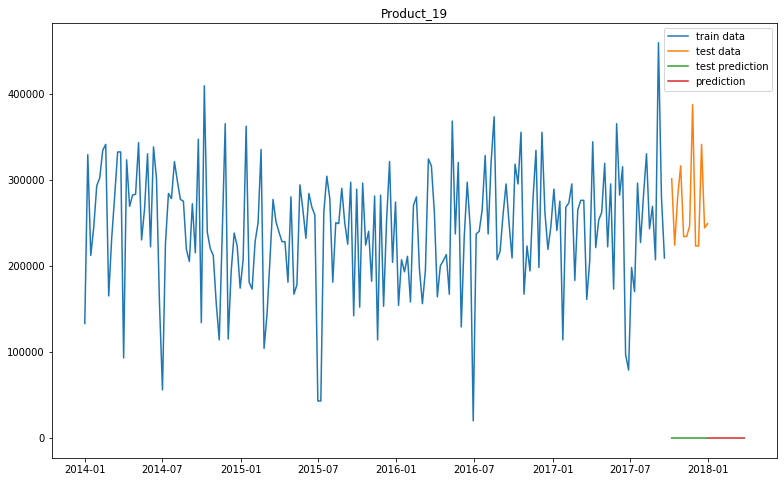

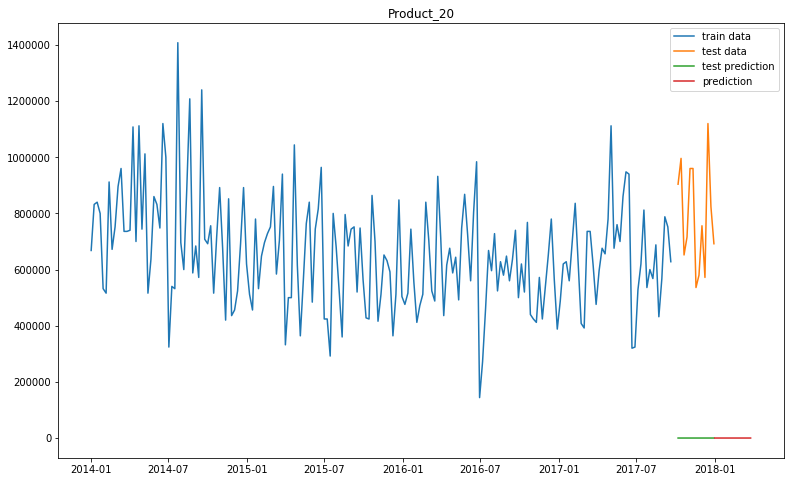

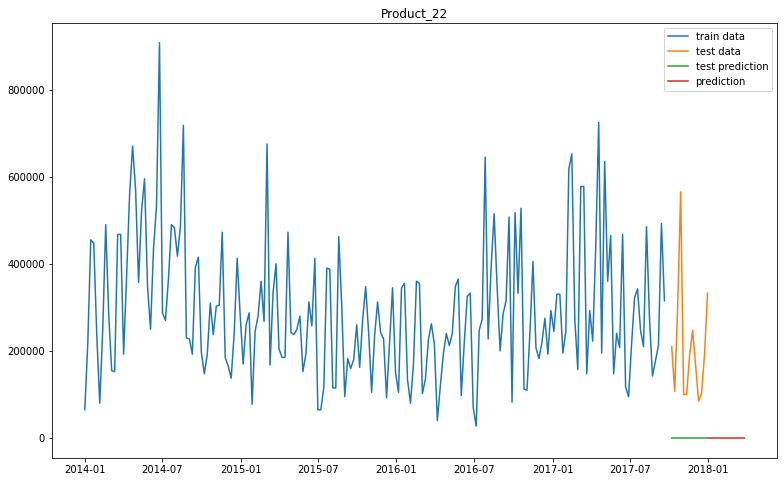

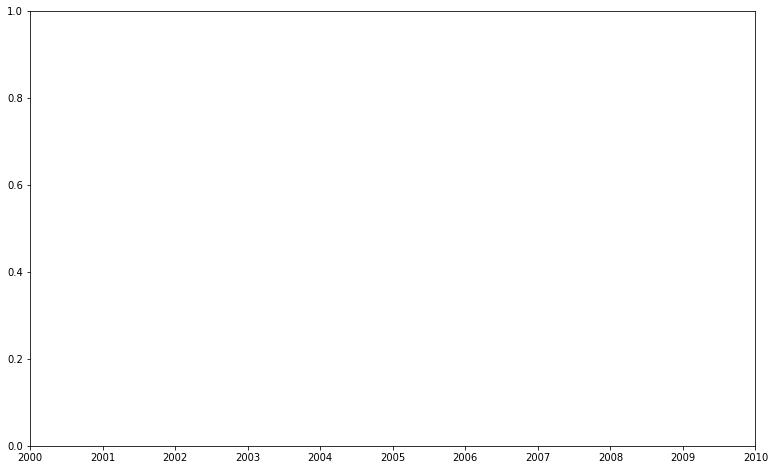

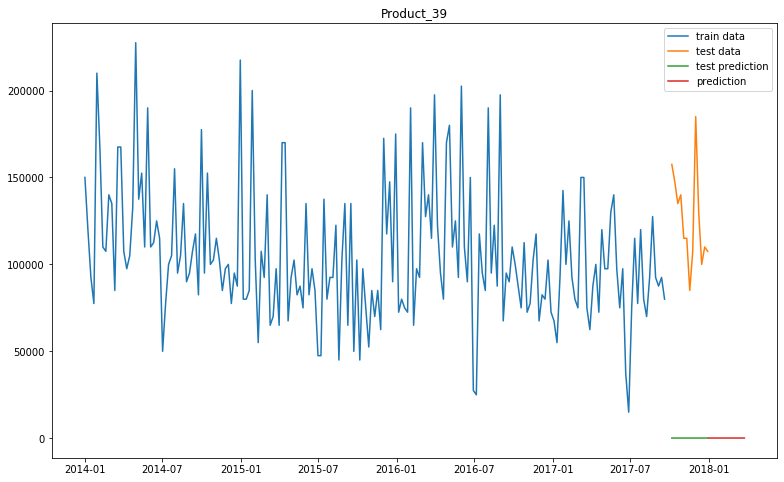

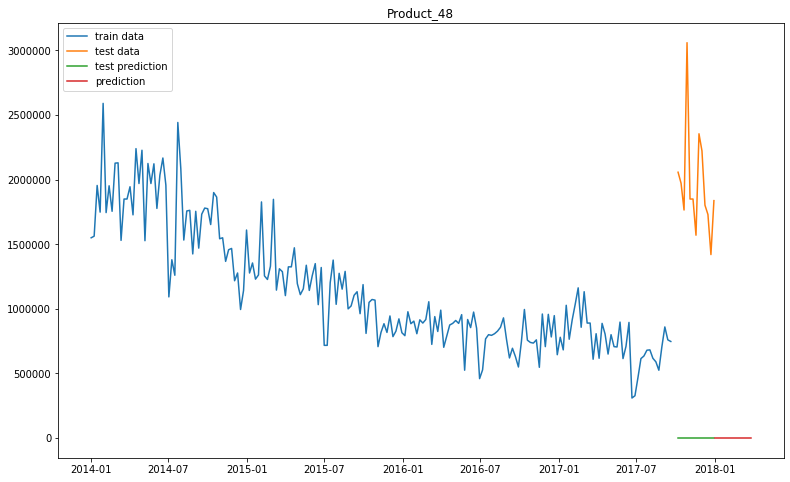

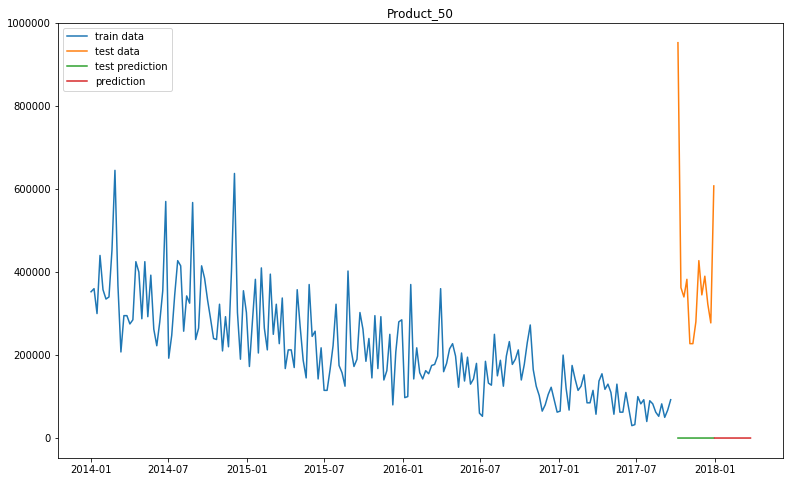

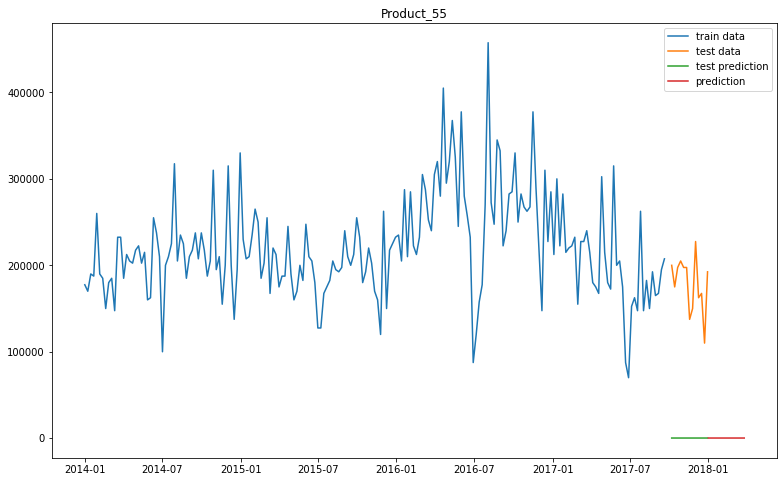

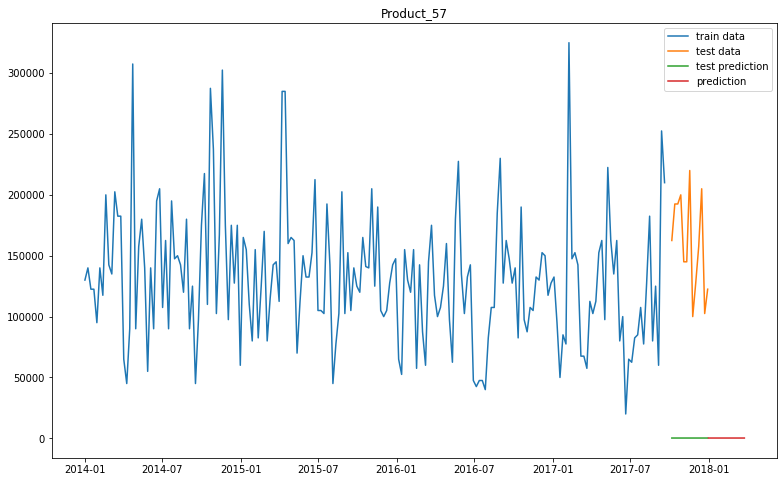

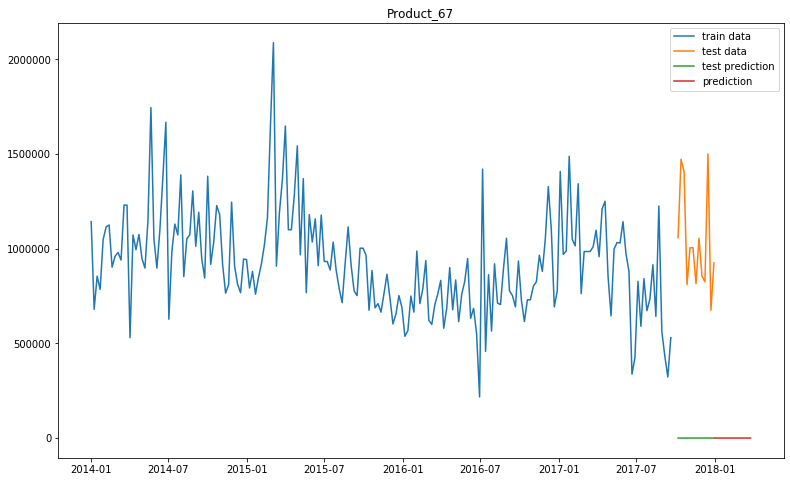

In [274]:
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.01, 15)

In [279]:
# NORMAL
products = list(range(0,10))
print(products)

trains = []
tests = []
predictions = []

for prod in products:
    train_set = BillingNormDataset(product=prod, ttp='train')
    test_set = BillingNormDataset(product=prod, ttp='test')
    predict_set = BillingNormDataset(product=prod, ttp='predict')
    trains.append(train_set)
    tests.append(test_set)
    predictions.append(predict_set)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

In [280]:
batch_size = 1

trains_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in trains]
tests_loaders = [DataLoader(dataset=x, batch_size=batch_size, shuffle=False) for x in tests]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [80669570311.72342]
Epoch [1/30], Step [20/182], Loss: [70385964405.58069]
Epoch [1/30], Step [30/182], Loss: [76495721152.7732]
Epoch [1/30], Step [40/182], Loss: [55358567182.09795]
Epoch [1/30], Step [50/182], Loss: [51471405578.97146]
Epoch [1/30], Step [60/182], Loss: [50693088846.16638]
Epoch [1/30], Step [70/182], Loss: [56367385525.20694]
Epoch [1/30], Step [80/182], Loss: [60505603012.58569]
Epoch [1/30], Step [90/182], Loss: [53992824517.42937]
Epoch [1/30], Step [100/182], Loss: [54674425820.20349]
Epoch [1/30], Step [110/182], Loss: [54247412902.66799]
Epoch [1/30], Step [120/182], Loss: [55799709157.50918]
Epoch [1/30], Step [130/182], Loss: [68789106377.57924]
Epoch [1/30], Step [140/182], Loss: [71162006940.666]
Epoch [1/30], Step [150/182], Loss: [66947284053.87146]
Epoch [1/30], Step [160/182], Loss: [62584230404.46302]
Epoch [1/30], Step [170/182], Loss: [71664882528.76625]
Epoch [1/30], Step [180/182], Loss: [58794262499.49984]
Epoc

Epoch [9/30], Step [100/182], Loss: [25350327939.33024]
Epoch [9/30], Step [110/182], Loss: [34428022749.97138]
Epoch [9/30], Step [120/182], Loss: [25283482285.701668]
Epoch [9/30], Step [130/182], Loss: [39793047924.047935]
Epoch [9/30], Step [140/182], Loss: [46689033334.72113]
Epoch [9/30], Step [150/182], Loss: [25850435690.001682]
Epoch [9/30], Step [160/182], Loss: [42969324067.94648]
Epoch [9/30], Step [170/182], Loss: [27500580326.957886]
Epoch [9/30], Step [180/182], Loss: [44103231953.738205]
Epoch [10/30], Step [10/182], Loss: [58618768869.51913]
Epoch [10/30], Step [20/182], Loss: [29372734921.25028]
Epoch [10/30], Step [30/182], Loss: [47312643672.94589]
Epoch [10/30], Step [40/182], Loss: [40597608765.094864]
Epoch [10/30], Step [50/182], Loss: [22815540178.354614]
Epoch [10/30], Step [60/182], Loss: [32755305044.337273]
Epoch [10/30], Step [70/182], Loss: [35116290196.80962]
Epoch [10/30], Step [80/182], Loss: [35622316353.827866]
Epoch [10/30], Step [90/182], Loss: [30

Epoch [17/30], Step [100/182], Loss: [3051133235.0960026]
Epoch [17/30], Step [110/182], Loss: [36840431996.60926]
Epoch [17/30], Step [120/182], Loss: [30074403197.786556]
Epoch [17/30], Step [130/182], Loss: [40314008660.46209]
Epoch [17/30], Step [140/182], Loss: [15472422465.463776]
Epoch [17/30], Step [150/182], Loss: [3609090800.729652]
Epoch [17/30], Step [160/182], Loss: [8732320384.116377]
Epoch [17/30], Step [170/182], Loss: [5497719442.829808]
Epoch [17/30], Step [180/182], Loss: [18420058953.933125]
Epoch [18/30], Step [10/182], Loss: [4281284289.0001388]
Epoch [18/30], Step [20/182], Loss: [7126295604.94973]
Epoch [18/30], Step [30/182], Loss: [19882262283.284363]
Epoch [18/30], Step [40/182], Loss: [7979521376.331052]
Epoch [18/30], Step [50/182], Loss: [11856047500.247847]
Epoch [18/30], Step [60/182], Loss: [12427633628.647387]
Epoch [18/30], Step [70/182], Loss: [11276884490.386353]
Epoch [18/30], Step [80/182], Loss: [40062209879.34405]
Epoch [18/30], Step [90/182], L

Epoch [25/30], Step [120/182], Loss: [15302074309.762568]
Epoch [25/30], Step [130/182], Loss: [7190934737.636774]
Epoch [25/30], Step [140/182], Loss: [3498822691.0575624]
Epoch [25/30], Step [150/182], Loss: [3935115288.089245]
Epoch [25/30], Step [160/182], Loss: [8037093436.478909]
Epoch [25/30], Step [170/182], Loss: [12761697893.174568]
Epoch [25/30], Step [180/182], Loss: [15306646881.06569]
Epoch [26/30], Step [10/182], Loss: [38837419814.15881]
Epoch [26/30], Step [20/182], Loss: [6046772867.945171]
Epoch [26/30], Step [30/182], Loss: [30866333107.588753]
Epoch [26/30], Step [40/182], Loss: [12117201732.872793]
Epoch [26/30], Step [50/182], Loss: [7390809592.326091]
Epoch [26/30], Step [60/182], Loss: [10421917729.023933]
Epoch [26/30], Step [70/182], Loss: [41221680950.917]
Epoch [26/30], Step [80/182], Loss: [9297365020.695976]
Epoch [26/30], Step [90/182], Loss: [6363264207.23993]
Epoch [26/30], Step [100/182], Loss: [9353563450.803463]
Epoch [26/30], Step [110/182], Loss: 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [199983968261.5433]
Epoch [1/30], Step [20/182], Loss: [238855730628.98645]
Epoch [1/30], Step [30/182], Loss: [388812340528.1776]
Epoch [1/30], Step [40/182], Loss: [331497423546.7821]
Epoch [1/30], Step [50/182], Loss: [252089094570.94962]
Epoch [1/30], Step [60/182], Loss: [174847547351.49155]
Epoch [1/30], Step [70/182], Loss: [302620684345.921]
Epoch [1/30], Step [80/182], Loss: [130851385952.91792]
Epoch [1/30], Step [90/182], Loss: [66772160915.5449]
Epoch [1/30], Step [100/182], Loss: [230584817398.1938]
Epoch [1/30], Step [110/182], Loss: [102295428376.71936]
Epoch [1/30], Step [120/182], Loss: [164478532084.09042]
Epoch [1/30], Step [130/182], Loss: [93542879274.50969]
Epoch [1/30], Step [140/182], Loss: [54700057240.89884]
Epoch [1/30], Step [150/182], Loss: [188505165143.7066]
Epoch [1/30], Step [160/182], Loss: [51629567766.78524]
Epoch [1/30], Step [170/182], Loss: [171339202688.80298]
Epoch [1/30], Step [180/182], Loss: [352481734367.98

Epoch [9/30], Step [80/182], Loss: [102734290470.49368]
Epoch [9/30], Step [90/182], Loss: [74665987783.24702]
Epoch [9/30], Step [100/182], Loss: [121005412610.89166]
Epoch [9/30], Step [110/182], Loss: [30924276207.774765]
Epoch [9/30], Step [120/182], Loss: [229265015953.24634]
Epoch [9/30], Step [130/182], Loss: [65685690615.53497]
Epoch [9/30], Step [140/182], Loss: [133465850783.80501]
Epoch [9/30], Step [150/182], Loss: [36680250259.03323]
Epoch [9/30], Step [160/182], Loss: [62588623008.6948]
Epoch [9/30], Step [170/182], Loss: [71760157448.79665]
Epoch [9/30], Step [180/182], Loss: [99260358707.56735]
Epoch [10/30], Step [10/182], Loss: [145673523259.19687]
Epoch [10/30], Step [20/182], Loss: [195978255888.28674]
Epoch [10/30], Step [30/182], Loss: [77489233777.30905]
Epoch [10/30], Step [40/182], Loss: [27883293670.76614]
Epoch [10/30], Step [50/182], Loss: [100612570652.5251]
Epoch [10/30], Step [60/182], Loss: [75291079738.36195]
Epoch [10/30], Step [70/182], Loss: [8031559

Epoch [17/30], Step [90/182], Loss: [72361912698.79451]
Epoch [17/30], Step [100/182], Loss: [56180315573.92839]
Epoch [17/30], Step [110/182], Loss: [92115631057.39421]
Epoch [17/30], Step [120/182], Loss: [57614909431.9806]
Epoch [17/30], Step [130/182], Loss: [76135555428.09477]
Epoch [17/30], Step [140/182], Loss: [140038993014.8382]
Epoch [17/30], Step [150/182], Loss: [21659112626.020947]
Epoch [17/30], Step [160/182], Loss: [28780136375.731903]
Epoch [17/30], Step [170/182], Loss: [88846863373.84613]
Epoch [17/30], Step [180/182], Loss: [276675518731.1704]
Epoch [18/30], Step [10/182], Loss: [31501840339.051285]
Epoch [18/30], Step [20/182], Loss: [122281874820.30846]
Epoch [18/30], Step [30/182], Loss: [86216799669.26683]
Epoch [18/30], Step [40/182], Loss: [34664273227.95816]
Epoch [18/30], Step [50/182], Loss: [156538494042.21695]
Epoch [18/30], Step [60/182], Loss: [44284278385.10998]
Epoch [18/30], Step [70/182], Loss: [45648954339.08416]
Epoch [18/30], Step [80/182], Loss:

Epoch [25/30], Step [140/182], Loss: [99568093406.92549]
Epoch [25/30], Step [150/182], Loss: [76002528917.01033]
Epoch [25/30], Step [160/182], Loss: [23265917076.42466]
Epoch [25/30], Step [170/182], Loss: [114914755533.8049]
Epoch [25/30], Step [180/182], Loss: [74716364787.17664]
Epoch [26/30], Step [10/182], Loss: [31205433714.255386]
Epoch [26/30], Step [20/182], Loss: [86539619836.8685]
Epoch [26/30], Step [30/182], Loss: [203232926899.96832]
Epoch [26/30], Step [40/182], Loss: [33356184434.23157]
Epoch [26/30], Step [50/182], Loss: [31719287689.853615]
Epoch [26/30], Step [60/182], Loss: [43301921047.208984]
Epoch [26/30], Step [70/182], Loss: [82940204318.60852]
Epoch [26/30], Step [80/182], Loss: [81172489517.27284]
Epoch [26/30], Step [90/182], Loss: [239386444062.4744]
Epoch [26/30], Step [100/182], Loss: [22136973926.01674]
Epoch [26/30], Step [110/182], Loss: [86885717523.08484]
Epoch [26/30], Step [120/182], Loss: [84774559817.13765]
Epoch [26/30], Step [130/182], Loss: 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [37479448499.97995]
Epoch [1/30], Step [20/182], Loss: [31075448086.369736]
Epoch [1/30], Step [30/182], Loss: [79841687289.23679]
Epoch [1/30], Step [40/182], Loss: [27455628634.638176]
Epoch [1/30], Step [50/182], Loss: [20693906530.06183]
Epoch [1/30], Step [60/182], Loss: [110273845649.97957]
Epoch [1/30], Step [70/182], Loss: [13251819964.739695]
Epoch [1/30], Step [80/182], Loss: [60928575135.352196]
Epoch [1/30], Step [90/182], Loss: [18448993009.02847]
Epoch [1/30], Step [100/182], Loss: [17234033403.990772]
Epoch [1/30], Step [110/182], Loss: [10185746626.698322]
Epoch [1/30], Step [120/182], Loss: [17748247723.27802]
Epoch [1/30], Step [130/182], Loss: [62190991612.42529]
Epoch [1/30], Step [140/182], Loss: [66035250780.56418]
Epoch [1/30], Step [150/182], Loss: [6663080480.707267]
Epoch [1/30], Step [160/182], Loss: [61327238076.9562]
Epoch [1/30], Step [170/182], Loss: [33034549379.1807]
Epoch [1/30], Step [180/182], Loss: [14511935508.043

Epoch [9/30], Step [30/182], Loss: [48917952149.79858]
Epoch [9/30], Step [40/182], Loss: [13674928550.323936]
Epoch [9/30], Step [50/182], Loss: [29269679858.821247]
Epoch [9/30], Step [60/182], Loss: [42126266093.8304]
Epoch [9/30], Step [70/182], Loss: [12859927950.308498]
Epoch [9/30], Step [80/182], Loss: [28010473160.577713]
Epoch [9/30], Step [90/182], Loss: [19187140120.795513]
Epoch [9/30], Step [100/182], Loss: [12982205481.885954]
Epoch [9/30], Step [110/182], Loss: [11320420743.484982]
Epoch [9/30], Step [120/182], Loss: [51678230782.599815]
Epoch [9/30], Step [130/182], Loss: [24974431341.74016]
Epoch [9/30], Step [140/182], Loss: [28502147954.31816]
Epoch [9/30], Step [150/182], Loss: [37374759825.76006]
Epoch [9/30], Step [160/182], Loss: [83479986971.53177]
Epoch [9/30], Step [170/182], Loss: [53313746166.156784]
Epoch [9/30], Step [180/182], Loss: [19706998040.350662]
Epoch [10/30], Step [10/182], Loss: [28069188400.035652]
Epoch [10/30], Step [20/182], Loss: [56755070

Epoch [17/30], Step [80/182], Loss: [22872085002.021587]
Epoch [17/30], Step [90/182], Loss: [17636979111.22112]
Epoch [17/30], Step [100/182], Loss: [13988144036.405325]
Epoch [17/30], Step [110/182], Loss: [21371649280.866154]
Epoch [17/30], Step [120/182], Loss: [35659568811.07399]
Epoch [17/30], Step [130/182], Loss: [30557440880.38227]
Epoch [17/30], Step [140/182], Loss: [51195318621.29109]
Epoch [17/30], Step [150/182], Loss: [4450151431.477597]
Epoch [17/30], Step [160/182], Loss: [49876113458.23542]
Epoch [17/30], Step [170/182], Loss: [33120323879.853966]
Epoch [17/30], Step [180/182], Loss: [26914982125.560074]
Epoch [18/30], Step [10/182], Loss: [129799300410.00726]
Epoch [18/30], Step [20/182], Loss: [72077960432.75023]
Epoch [18/30], Step [30/182], Loss: [26808672539.90067]
Epoch [18/30], Step [40/182], Loss: [12680019003.375717]
Epoch [18/30], Step [50/182], Loss: [23936110666.03927]
Epoch [18/30], Step [60/182], Loss: [40373271133.4906]
Epoch [18/30], Step [70/182], Los

Epoch [25/30], Step [70/182], Loss: [12572742018.794872]
Epoch [25/30], Step [80/182], Loss: [17150457909.958193]
Epoch [25/30], Step [90/182], Loss: [6462834881.903485]
Epoch [25/30], Step [100/182], Loss: [11541332791.992037]
Epoch [25/30], Step [110/182], Loss: [9415733992.813604]
Epoch [25/30], Step [120/182], Loss: [12126290374.999405]
Epoch [25/30], Step [130/182], Loss: [29834415627.399483]
Epoch [25/30], Step [140/182], Loss: [39016755682.32309]
Epoch [25/30], Step [150/182], Loss: [21551975902.94887]
Epoch [25/30], Step [160/182], Loss: [97499103873.49335]
Epoch [25/30], Step [170/182], Loss: [36138045375.619064]
Epoch [25/30], Step [180/182], Loss: [28482779331.986588]
Epoch [26/30], Step [10/182], Loss: [27716059336.809956]
Epoch [26/30], Step [20/182], Loss: [74953163073.46523]
Epoch [26/30], Step [30/182], Loss: [30802356914.943504]
Epoch [26/30], Step [40/182], Loss: [11961922901.615034]
Epoch [26/30], Step [50/182], Loss: [28068481457.687588]
Epoch [26/30], Step [60/182]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/180], Loss: [37120931122.02397]
Epoch [1/30], Step [20/180], Loss: [75432059479.09016]
Epoch [1/30], Step [30/180], Loss: [106370326598.20851]
Epoch [1/30], Step [40/180], Loss: [91641583986.2153]
Epoch [1/30], Step [50/180], Loss: [84769973040.43558]
Epoch [1/30], Step [60/180], Loss: [42638195664.03845]
Epoch [1/30], Step [70/180], Loss: [19310368692.735664]
Epoch [1/30], Step [80/180], Loss: [49789296215.4225]
Epoch [1/30], Step [90/180], Loss: [72717630287.94446]
Epoch [1/30], Step [100/180], Loss: [35450019303.8776]
Epoch [1/30], Step [110/180], Loss: [93035023256.57828]
Epoch [1/30], Step [120/180], Loss: [16282979592.606693]
Epoch [1/30], Step [130/180], Loss: [30933713093.553215]
Epoch [1/30], Step [140/180], Loss: [21637232157.1702]
Epoch [1/30], Step [150/180], Loss: [26684476850.425644]
Epoch [1/30], Step [160/180], Loss: [30393397157.43542]
Epoch [1/30], Step [170/180], Loss: [10645760220.850786]
Epoch [1/30], Step [180/180], Loss: [60740508896.92868]

Epoch [9/30], Step [50/180], Loss: [23672174060.689297]
Epoch [9/30], Step [60/180], Loss: [6800166532.320229]
Epoch [9/30], Step [70/180], Loss: [20986489251.206867]
Epoch [9/30], Step [80/180], Loss: [8330877033.437067]
Epoch [9/30], Step [90/180], Loss: [14966351018.048824]
Epoch [9/30], Step [100/180], Loss: [127313089536.1576]
Epoch [9/30], Step [110/180], Loss: [8734678371.865753]
Epoch [9/30], Step [120/180], Loss: [17062818290.80759]
Epoch [9/30], Step [130/180], Loss: [16216392850.344559]
Epoch [9/30], Step [140/180], Loss: [42467388542.27807]
Epoch [9/30], Step [150/180], Loss: [7086916363.522776]
Epoch [9/30], Step [160/180], Loss: [46586848008.37994]
Epoch [9/30], Step [170/180], Loss: [65464107959.811844]
Epoch [9/30], Step [180/180], Loss: [68739305046.81702]
Epoch [10/30], Step [10/180], Loss: [6915127020.548991]
Epoch [10/30], Step [20/180], Loss: [11214039694.818062]
Epoch [10/30], Step [30/180], Loss: [20506222584.51744]
Epoch [10/30], Step [40/180], Loss: [1179658446

Epoch [17/30], Step [80/180], Loss: [19015804373.800014]
Epoch [17/30], Step [90/180], Loss: [13534050698.62454]
Epoch [17/30], Step [100/180], Loss: [15463328676.831797]
Epoch [17/30], Step [110/180], Loss: [21815062496.511288]
Epoch [17/30], Step [120/180], Loss: [23274114480.001762]
Epoch [17/30], Step [130/180], Loss: [31061536214.954487]
Epoch [17/30], Step [140/180], Loss: [15680596905.90125]
Epoch [17/30], Step [150/180], Loss: [25339256425.425602]
Epoch [17/30], Step [160/180], Loss: [116012873329.85965]
Epoch [17/30], Step [170/180], Loss: [26763419579.453396]
Epoch [17/30], Step [180/180], Loss: [12337594922.196852]
Epoch [18/30], Step [10/180], Loss: [84694433111.99736]
Epoch [18/30], Step [20/180], Loss: [27069364622.141388]
Epoch [18/30], Step [30/180], Loss: [9397213172.274733]
Epoch [18/30], Step [40/180], Loss: [5382564728.712058]
Epoch [18/30], Step [50/180], Loss: [23114051290.225212]
Epoch [18/30], Step [60/180], Loss: [9052948213.08611]
Epoch [18/30], Step [70/180],

Epoch [25/30], Step [110/180], Loss: [12614764162.062513]
Epoch [25/30], Step [120/180], Loss: [18293774433.63658]
Epoch [25/30], Step [130/180], Loss: [32805294231.004807]
Epoch [25/30], Step [140/180], Loss: [23637180840.4856]
Epoch [25/30], Step [150/180], Loss: [28253826255.46179]
Epoch [25/30], Step [160/180], Loss: [16072768791.261763]
Epoch [25/30], Step [170/180], Loss: [11424539752.62879]
Epoch [25/30], Step [180/180], Loss: [20641178692.49586]
Epoch [26/30], Step [10/180], Loss: [6899494037.422854]
Epoch [26/30], Step [20/180], Loss: [27465463363.71931]
Epoch [26/30], Step [30/180], Loss: [122306210637.18724]
Epoch [26/30], Step [40/180], Loss: [9668790944.43282]
Epoch [26/30], Step [50/180], Loss: [96474999867.48259]
Epoch [26/30], Step [60/180], Loss: [64076042402.32127]
Epoch [26/30], Step [70/180], Loss: [15177432146.654938]
Epoch [26/30], Step [80/180], Loss: [9124760474.319824]
Epoch [26/30], Step [90/180], Loss: [7476139122.357]
Epoch [26/30], Step [100/180], Loss: [15

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch [1/30], Step [40/182], Loss: [100693279132.23752]
Epoch [1/30], Step [50/182], Loss: [62606386228.2439]
Epoch [1/30], Step [60/182], Loss: [43728731481.55819]
Epoch [1/30], Step [70/182], Loss: [13728217207.719276]
Epoch [1/30], Step [80/182], Loss: [26933150894.522835]
Epoch [1/30], Step [90/182], Loss: [12279634364.821148]
Epoch [1/30], Step [100/182], Loss: [17837629716.95141]
Epoch [1/30], Step [110/182], Loss: [3243091203.953324]
Epoch [1/30], Step [120/182], Loss: [87008533633.57845]
Epoch [1/30], Step [130/182], Loss: [3245388536.727239]
Epoch [1/30], Step [140/182], Loss: [3260541259.5581713]
Epoch [1/30], Step [150/182], Loss: [37592694249.674965]
Epoch [1/30], Step [160/182], Loss: [23107175008.95097]
Epoch [1/30], Step [170/182], Loss: [55281484253.45451]
Epoch [1/30], Step [180/182], Loss: [8874261823.479929]
Epoch [2/30], Step [10/182], Loss: [10334218361.178625]
Epoch [2/30], Step [20/182], Loss: [15381997415.607708]
Epoch [2/30], Step [30/182], Loss: [38796475497.

Epoch [9/30], Step [80/182], Loss: [1249266751.659808]
Epoch [9/30], Step [90/182], Loss: [4863306538.108289]
Epoch [9/30], Step [100/182], Loss: [10468349723.831053]
Epoch [9/30], Step [110/182], Loss: [3470925294.549966]
Epoch [9/30], Step [120/182], Loss: [24397449724.165283]
Epoch [9/30], Step [130/182], Loss: [2770656939.5771155]
Epoch [9/30], Step [140/182], Loss: [1028360152.7983012]
Epoch [9/30], Step [150/182], Loss: [6885416580.089247]
Epoch [9/30], Step [160/182], Loss: [8915718486.446182]
Epoch [9/30], Step [170/182], Loss: [8237724139.229169]
Epoch [9/30], Step [180/182], Loss: [975791864.0118356]
Epoch [10/30], Step [10/182], Loss: [15280799433.853926]
Epoch [10/30], Step [20/182], Loss: [1441426015.4803545]
Epoch [10/30], Step [30/182], Loss: [11502565703.210812]
Epoch [10/30], Step [40/182], Loss: [9040131998.595171]
Epoch [10/30], Step [50/182], Loss: [6055373848.996696]
Epoch [10/30], Step [60/182], Loss: [4218146651.4517293]
Epoch [10/30], Step [70/182], Loss: [43952

Epoch [17/30], Step [90/182], Loss: [2833506992.1203303]
Epoch [17/30], Step [100/182], Loss: [6974779119.052304]
Epoch [17/30], Step [110/182], Loss: [1778817030.7853575]
Epoch [17/30], Step [120/182], Loss: [4545510398.8278055]
Epoch [17/30], Step [130/182], Loss: [3062666588.21972]
Epoch [17/30], Step [140/182], Loss: [2271173512.105949]
Epoch [17/30], Step [150/182], Loss: [2575026909.1147485]
Epoch [17/30], Step [160/182], Loss: [922259784.5110867]
Epoch [17/30], Step [170/182], Loss: [5666651272.144615]
Epoch [17/30], Step [180/182], Loss: [1620244284.8330438]
Epoch [18/30], Step [10/182], Loss: [1752461767.6587372]
Epoch [18/30], Step [20/182], Loss: [1414131923.4486983]
Epoch [18/30], Step [30/182], Loss: [1059300991.6838199]
Epoch [18/30], Step [40/182], Loss: [783067559.31928]
Epoch [18/30], Step [50/182], Loss: [6601171537.511795]
Epoch [18/30], Step [60/182], Loss: [1487893922.2114449]
Epoch [18/30], Step [70/182], Loss: [2776405131.183397]
Epoch [18/30], Step [80/182], Los

Epoch [25/30], Step [120/182], Loss: [2669193122.658694]
Epoch [25/30], Step [130/182], Loss: [3562796446.6736813]
Epoch [25/30], Step [140/182], Loss: [1582200889.557597]
Epoch [25/30], Step [150/182], Loss: [3519633101.846816]
Epoch [25/30], Step [160/182], Loss: [1383728853.9194264]
Epoch [25/30], Step [170/182], Loss: [1053144889.0678924]
Epoch [25/30], Step [180/182], Loss: [1302785643.3302116]
Epoch [26/30], Step [10/182], Loss: [3044923586.729839]
Epoch [26/30], Step [20/182], Loss: [2500865953.9162235]
Epoch [26/30], Step [30/182], Loss: [887812903.7269167]
Epoch [26/30], Step [40/182], Loss: [1575894407.119304]
Epoch [26/30], Step [50/182], Loss: [6254158479.098776]
Epoch [26/30], Step [60/182], Loss: [2527151854.3548064]
Epoch [26/30], Step [70/182], Loss: [2763593806.9744067]
Epoch [26/30], Step [80/182], Loss: [1094271612.0492876]
Epoch [26/30], Step [90/182], Loss: [2519763860.95691]
Epoch [26/30], Step [100/182], Loss: [2561261858.1580176]
Epoch [26/30], Step [110/182], L

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [3470279129987.9746]
Epoch [1/30], Step [20/182], Loss: [3199217408417.6714]
Epoch [1/30], Step [30/182], Loss: [2903070430875.8687]
Epoch [1/30], Step [40/182], Loss: [2095538435135.983]
Epoch [1/30], Step [50/182], Loss: [1592685028305.8816]
Epoch [1/30], Step [60/182], Loss: [1469273369616.2686]
Epoch [1/30], Step [70/182], Loss: [1122055245448.2495]
Epoch [1/30], Step [80/182], Loss: [1132047499262.056]
Epoch [1/30], Step [90/182], Loss: [828284542071.9044]
Epoch [1/30], Step [100/182], Loss: [634934434346.6892]
Epoch [1/30], Step [110/182], Loss: [661842289047.709]
Epoch [1/30], Step [120/182], Loss: [637436529221.7705]
Epoch [1/30], Step [130/182], Loss: [459826133934.4991]
Epoch [1/30], Step [140/182], Loss: [514645500733.92224]
Epoch [1/30], Step [150/182], Loss: [564706273857.0007]
Epoch [1/30], Step [160/182], Loss: [725037545622.6945]
Epoch [1/30], Step [170/182], Loss: [494978353872.2302]
Epoch [1/30], Step [180/182], Loss: [340960751000.8

Epoch [9/30], Step [30/182], Loss: [1514392269844.984]
Epoch [9/30], Step [40/182], Loss: [1038521258984.7269]
Epoch [9/30], Step [50/182], Loss: [1209226263708.0134]
Epoch [9/30], Step [60/182], Loss: [1701418189760.261]
Epoch [9/30], Step [70/182], Loss: [702816826577.4314]
Epoch [9/30], Step [80/182], Loss: [557765958587.9797]
Epoch [9/30], Step [90/182], Loss: [468001660148.97504]
Epoch [9/30], Step [100/182], Loss: [303534834723.9042]
Epoch [9/30], Step [110/182], Loss: [330334439335.8692]
Epoch [9/30], Step [120/182], Loss: [249812671653.04886]
Epoch [9/30], Step [130/182], Loss: [309042728829.7998]
Epoch [9/30], Step [140/182], Loss: [175159509139.93164]
Epoch [9/30], Step [150/182], Loss: [274028717570.65994]
Epoch [9/30], Step [160/182], Loss: [376938828382.4088]
Epoch [9/30], Step [170/182], Loss: [261361998299.17535]
Epoch [9/30], Step [180/182], Loss: [178510136390.4418]
Epoch [10/30], Step [10/182], Loss: [2035963232899.663]
Epoch [10/30], Step [20/182], Loss: [11766946594

Epoch [17/30], Step [50/182], Loss: [95044992889.19154]
Epoch [17/30], Step [60/182], Loss: [36494108625.65591]
Epoch [17/30], Step [70/182], Loss: [1111311258851.286]
Epoch [17/30], Step [80/182], Loss: [27429625176.343918]
Epoch [17/30], Step [90/182], Loss: [89019793680.83961]
Epoch [17/30], Step [100/182], Loss: [85666270745.89705]
Epoch [17/30], Step [110/182], Loss: [21574743493.12347]
Epoch [17/30], Step [120/182], Loss: [95790858886.87769]
Epoch [17/30], Step [130/182], Loss: [124538217617.53148]
Epoch [17/30], Step [140/182], Loss: [445253331038.3124]
Epoch [17/30], Step [150/182], Loss: [331800668039.6385]
Epoch [17/30], Step [160/182], Loss: [43768118488.692665]
Epoch [17/30], Step [170/182], Loss: [50247237798.24793]
Epoch [17/30], Step [180/182], Loss: [94828253661.303]
Epoch [18/30], Step [10/182], Loss: [893006083745.8779]
Epoch [18/30], Step [20/182], Loss: [1433431328021.73]
Epoch [18/30], Step [30/182], Loss: [110684637806.81276]
Epoch [18/30], Step [40/182], Loss: [1

Epoch [25/30], Step [70/182], Loss: [475622935922.65106]
Epoch [25/30], Step [80/182], Loss: [108021183207.42322]
Epoch [25/30], Step [90/182], Loss: [163721034778.23138]
Epoch [25/30], Step [100/182], Loss: [8097611801.4106865]
Epoch [25/30], Step [110/182], Loss: [62797800341.93358]
Epoch [25/30], Step [120/182], Loss: [51220817680.459114]
Epoch [25/30], Step [130/182], Loss: [459884307513.8903]
Epoch [25/30], Step [140/182], Loss: [59461854963.371254]
Epoch [25/30], Step [150/182], Loss: [20328356941.863777]
Epoch [25/30], Step [160/182], Loss: [29493099112.368183]
Epoch [25/30], Step [170/182], Loss: [102071873233.04395]
Epoch [25/30], Step [180/182], Loss: [41310410132.81393]
Epoch [26/30], Step [10/182], Loss: [374493764221.34143]
Epoch [26/30], Step [20/182], Loss: [514494548922.1352]
Epoch [26/30], Step [30/182], Loss: [227543407490.47647]
Epoch [26/30], Step [40/182], Loss: [87396618503.60452]
Epoch [26/30], Step [50/182], Loss: [204292852442.64703]
Epoch [26/30], Step [60/182

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [577705061433.6545]
Epoch [1/30], Step [20/182], Loss: [1955931556036.0889]
Epoch [1/30], Step [30/182], Loss: [346185049197.1275]
Epoch [1/30], Step [40/182], Loss: [102760391748.79623]
Epoch [1/30], Step [50/182], Loss: [2516373302011.4307]
Epoch [1/30], Step [60/182], Loss: [641166015887.7263]
Epoch [1/30], Step [70/182], Loss: [2375596349993.909]
Epoch [1/30], Step [80/182], Loss: [394341226329.067]
Epoch [1/30], Step [90/182], Loss: [218472398188.71625]
Epoch [1/30], Step [100/182], Loss: [944451612799.3142]
Epoch [1/30], Step [110/182], Loss: [1037584124899.963]
Epoch [1/30], Step [120/182], Loss: [306911065934.5894]
Epoch [1/30], Step [130/182], Loss: [109971455229.28911]
Epoch [1/30], Step [140/182], Loss: [583479274314.5806]
Epoch [1/30], Step [150/182], Loss: [671090376133.0206]
Epoch [1/30], Step [160/182], Loss: [12448223958.041634]
Epoch [1/30], Step [170/182], Loss: [346940851066.37665]
Epoch [1/30], Step [180/182], Loss: [6537597497.392

Epoch [9/30], Step [90/182], Loss: [359815244342.3346]
Epoch [9/30], Step [100/182], Loss: [296868805746.7371]
Epoch [9/30], Step [110/182], Loss: [23968972609.143272]
Epoch [9/30], Step [120/182], Loss: [276596146591.08344]
Epoch [9/30], Step [130/182], Loss: [49962047724.20451]
Epoch [9/30], Step [140/182], Loss: [149136687882.08765]
Epoch [9/30], Step [150/182], Loss: [118200850223.43976]
Epoch [9/30], Step [160/182], Loss: [77944253544.22018]
Epoch [9/30], Step [170/182], Loss: [61574063453.153175]
Epoch [9/30], Step [180/182], Loss: [33594639413.241978]
Epoch [10/30], Step [10/182], Loss: [126985615885.37958]
Epoch [10/30], Step [20/182], Loss: [483829566381.1925]
Epoch [10/30], Step [30/182], Loss: [90115890580.61414]
Epoch [10/30], Step [40/182], Loss: [80245852595.52573]
Epoch [10/30], Step [50/182], Loss: [464710835476.0305]
Epoch [10/30], Step [60/182], Loss: [9352925573.842087]
Epoch [10/30], Step [70/182], Loss: [478773082660.2276]
Epoch [10/30], Step [80/182], Loss: [12253

Epoch [17/30], Step [130/182], Loss: [22574990124.79403]
Epoch [17/30], Step [140/182], Loss: [70667867246.30838]
Epoch [17/30], Step [150/182], Loss: [12447710934.139608]
Epoch [17/30], Step [160/182], Loss: [8244592810.807971]
Epoch [17/30], Step [170/182], Loss: [25582305201.277737]
Epoch [17/30], Step [180/182], Loss: [5899801097.627862]
Epoch [18/30], Step [10/182], Loss: [16928808443.828804]
Epoch [18/30], Step [20/182], Loss: [40731293213.70962]
Epoch [18/30], Step [30/182], Loss: [13082142472.231674]
Epoch [18/30], Step [40/182], Loss: [158074946952.05682]
Epoch [18/30], Step [50/182], Loss: [6158473523.279349]
Epoch [18/30], Step [60/182], Loss: [5226103856.020053]
Epoch [18/30], Step [70/182], Loss: [155282688095.5051]
Epoch [18/30], Step [80/182], Loss: [16206503079.296783]
Epoch [18/30], Step [90/182], Loss: [11557914620.701008]
Epoch [18/30], Step [100/182], Loss: [7215054465.675877]
Epoch [18/30], Step [110/182], Loss: [57593273484.33335]
Epoch [18/30], Step [120/182], Lo

Epoch [25/30], Step [170/182], Loss: [5801022650.669253]
Epoch [25/30], Step [180/182], Loss: [1488585107.3760529]
Epoch [26/30], Step [10/182], Loss: [35691830327.55718]
Epoch [26/30], Step [20/182], Loss: [71776546107.83589]
Epoch [26/30], Step [30/182], Loss: [49075255775.73942]
Epoch [26/30], Step [40/182], Loss: [21913759961.28489]
Epoch [26/30], Step [50/182], Loss: [46504810017.07028]
Epoch [26/30], Step [60/182], Loss: [61688676610.90946]
Epoch [26/30], Step [70/182], Loss: [8476591856.246908]
Epoch [26/30], Step [80/182], Loss: [11706715929.229115]
Epoch [26/30], Step [90/182], Loss: [36220732205.64143]
Epoch [26/30], Step [100/182], Loss: [6868494595.39835]
Epoch [26/30], Step [110/182], Loss: [3665358914.9090075]
Epoch [26/30], Step [120/182], Loss: [8251552676.978109]
Epoch [26/30], Step [130/182], Loss: [14010752224.809969]
Epoch [26/30], Step [140/182], Loss: [20399165707.323906]
Epoch [26/30], Step [150/182], Loss: [17160850926.505535]
Epoch [26/30], Step [160/182], Loss

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [117213067308.06865]
Epoch [1/30], Step [20/182], Loss: [4885207066.824455]
Epoch [1/30], Step [30/182], Loss: [11620321263.12057]
Epoch [1/30], Step [40/182], Loss: [54014903951.838135]
Epoch [1/30], Step [50/182], Loss: [5413080356.702552]
Epoch [1/30], Step [60/182], Loss: [119327189795.51155]
Epoch [1/30], Step [70/182], Loss: [3806489603.4384594]
Epoch [1/30], Step [80/182], Loss: [935768411.4826758]
Epoch [1/30], Step [90/182], Loss: [67602216994.85829]
Epoch [1/30], Step [100/182], Loss: [30275513528.0854]
Epoch [1/30], Step [110/182], Loss: [5671313078.8771515]
Epoch [1/30], Step [120/182], Loss: [106283612772.95964]
Epoch [1/30], Step [130/182], Loss: [53393295445.48729]
Epoch [1/30], Step [140/182], Loss: [14449314037.636747]
Epoch [1/30], Step [150/182], Loss: [3661615506.8861365]
Epoch [1/30], Step [160/182], Loss: [68376240024.31032]
Epoch [1/30], Step [170/182], Loss: [48707128749.84079]
Epoch [1/30], Step [180/182], Loss: [2327441755.59

Epoch [9/30], Step [40/182], Loss: [9697574199.66693]
Epoch [9/30], Step [50/182], Loss: [2167893348.9587617]
Epoch [9/30], Step [60/182], Loss: [811280621.4958904]
Epoch [9/30], Step [70/182], Loss: [9615806021.326847]
Epoch [9/30], Step [80/182], Loss: [3842159615.4569807]
Epoch [9/30], Step [90/182], Loss: [4274690913.4370074]
Epoch [9/30], Step [100/182], Loss: [8549490112.021083]
Epoch [9/30], Step [110/182], Loss: [2831856414.093702]
Epoch [9/30], Step [120/182], Loss: [8020034017.94392]
Epoch [9/30], Step [130/182], Loss: [10358375807.667969]
Epoch [9/30], Step [140/182], Loss: [5840975411.663156]
Epoch [9/30], Step [150/182], Loss: [8977585346.916643]
Epoch [9/30], Step [160/182], Loss: [5049827906.150116]
Epoch [9/30], Step [170/182], Loss: [11419435849.523403]
Epoch [9/30], Step [180/182], Loss: [5838062650.866149]
Epoch [10/30], Step [10/182], Loss: [4642064437.629472]
Epoch [10/30], Step [20/182], Loss: [11911750205.922302]
Epoch [10/30], Step [30/182], Loss: [2136917675.97

Epoch [17/30], Step [90/182], Loss: [11326484706.172264]
Epoch [17/30], Step [100/182], Loss: [2318579641.861885]
Epoch [17/30], Step [110/182], Loss: [23540607573.004807]
Epoch [17/30], Step [120/182], Loss: [31552358789.22956]
Epoch [17/30], Step [130/182], Loss: [28533023618.467155]
Epoch [17/30], Step [140/182], Loss: [2137127117.1088157]
Epoch [17/30], Step [150/182], Loss: [9520184673.165327]
Epoch [17/30], Step [160/182], Loss: [1488919818.0811224]
Epoch [17/30], Step [170/182], Loss: [6564373218.803197]
Epoch [17/30], Step [180/182], Loss: [14735382023.664993]
Epoch [18/30], Step [10/182], Loss: [772550376.047335]
Epoch [18/30], Step [20/182], Loss: [10584119663.69127]
Epoch [18/30], Step [30/182], Loss: [3463004005.8524804]
Epoch [18/30], Step [40/182], Loss: [12983547667.475912]
Epoch [18/30], Step [50/182], Loss: [15233933305.676826]
Epoch [18/30], Step [60/182], Loss: [2792826486.49836]
Epoch [18/30], Step [70/182], Loss: [3750026846.2760444]
Epoch [18/30], Step [80/182], L

Epoch [25/30], Step [100/182], Loss: [2247282056.600949]
Epoch [25/30], Step [110/182], Loss: [2406007502.96309]
Epoch [25/30], Step [120/182], Loss: [7935105041.310685]
Epoch [25/30], Step [130/182], Loss: [16566111788.295229]
Epoch [25/30], Step [140/182], Loss: [4322669189.798165]
Epoch [25/30], Step [150/182], Loss: [11357898367.408401]
Epoch [25/30], Step [160/182], Loss: [6990828289.6384]
Epoch [25/30], Step [170/182], Loss: [4147753952.545673]
Epoch [25/30], Step [180/182], Loss: [3707983017.2643647]
Epoch [26/30], Step [10/182], Loss: [5877246696.167117]
Epoch [26/30], Step [20/182], Loss: [9395035285.439175]
Epoch [26/30], Step [30/182], Loss: [10534604522.25018]
Epoch [26/30], Step [40/182], Loss: [4325007383.2752905]
Epoch [26/30], Step [50/182], Loss: [24067560614.87118]
Epoch [26/30], Step [60/182], Loss: [11616395463.745632]
Epoch [26/30], Step [70/182], Loss: [1013928850.9542735]
Epoch [26/30], Step [80/182], Loss: [3493969132.169808]
Epoch [26/30], Step [90/182], Loss: 

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [16196345647.07222]
Epoch [1/30], Step [20/182], Loss: [2021894802.1509745]
Epoch [1/30], Step [30/182], Loss: [2494373300.915362]
Epoch [1/30], Step [40/182], Loss: [11317270347.921404]
Epoch [1/30], Step [50/182], Loss: [3994615195.979328]
Epoch [1/30], Step [60/182], Loss: [7027319958.489101]
Epoch [1/30], Step [70/182], Loss: [1662804674.709042]
Epoch [1/30], Step [80/182], Loss: [1897519435.5410178]
Epoch [1/30], Step [90/182], Loss: [2761551099.6467576]
Epoch [1/30], Step [100/182], Loss: [7169408649.923374]
Epoch [1/30], Step [110/182], Loss: [2672508920.6049905]
Epoch [1/30], Step [120/182], Loss: [3772967930.162286]
Epoch [1/30], Step [130/182], Loss: [7258626135.55029]
Epoch [1/30], Step [140/182], Loss: [2237586622.5947237]
Epoch [1/30], Step [150/182], Loss: [2810977710.5698423]
Epoch [1/30], Step [160/182], Loss: [6433284359.314636]
Epoch [1/30], Step [170/182], Loss: [3817567973.2795987]
Epoch [1/30], Step [180/182], Loss: [1409658860.88

Epoch [9/30], Step [90/182], Loss: [2179389588.572515]
Epoch [9/30], Step [100/182], Loss: [1402441368.182107]
Epoch [9/30], Step [110/182], Loss: [4421502912.329895]
Epoch [9/30], Step [120/182], Loss: [2564406474.3078113]
Epoch [9/30], Step [130/182], Loss: [3560087840.071986]
Epoch [9/30], Step [140/182], Loss: [3505185228.0128036]
Epoch [9/30], Step [150/182], Loss: [4001013353.691562]
Epoch [9/30], Step [160/182], Loss: [5424205379.903428]
Epoch [9/30], Step [170/182], Loss: [2576440961.2206607]
Epoch [9/30], Step [180/182], Loss: [1497682549.9622216]
Epoch [10/30], Step [10/182], Loss: [7392548496.8582945]
Epoch [10/30], Step [20/182], Loss: [8142699792.095966]
Epoch [10/30], Step [30/182], Loss: [2275275994.0711536]
Epoch [10/30], Step [40/182], Loss: [12106479137.268913]
Epoch [10/30], Step [50/182], Loss: [3132401530.1301484]
Epoch [10/30], Step [60/182], Loss: [10108344495.951353]
Epoch [10/30], Step [70/182], Loss: [2186379089.964136]
Epoch [10/30], Step [80/182], Loss: [222

Epoch [17/30], Step [140/182], Loss: [3081175785.098485]
Epoch [17/30], Step [150/182], Loss: [2958345553.6887484]
Epoch [17/30], Step [160/182], Loss: [5326951595.242243]
Epoch [17/30], Step [170/182], Loss: [4459657509.8870125]
Epoch [17/30], Step [180/182], Loss: [1429969335.1466768]
Epoch [18/30], Step [10/182], Loss: [9595883851.089092]
Epoch [18/30], Step [20/182], Loss: [2088238452.4585576]
Epoch [18/30], Step [30/182], Loss: [11227474586.633615]
Epoch [18/30], Step [40/182], Loss: [18581207815.975414]
Epoch [18/30], Step [50/182], Loss: [2214642786.4095263]
Epoch [18/30], Step [60/182], Loss: [4041872796.343253]
Epoch [18/30], Step [70/182], Loss: [2187448310.406273]
Epoch [18/30], Step [80/182], Loss: [2527811978.514433]
Epoch [18/30], Step [90/182], Loss: [3253608988.8822274]
Epoch [18/30], Step [100/182], Loss: [4198704788.7825255]
Epoch [18/30], Step [110/182], Loss: [1967884368.50701]
Epoch [18/30], Step [120/182], Loss: [3138243359.573174]
Epoch [18/30], Step [130/182], L

Epoch [26/30], Step [10/182], Loss: [5923164378.415482]
Epoch [26/30], Step [20/182], Loss: [2084549821.0319889]
Epoch [26/30], Step [30/182], Loss: [3026289733.680686]
Epoch [26/30], Step [40/182], Loss: [8534977553.235115]
Epoch [26/30], Step [50/182], Loss: [2994065113.081731]
Epoch [26/30], Step [60/182], Loss: [4034137726.87821]
Epoch [26/30], Step [70/182], Loss: [2147170008.4573867]
Epoch [26/30], Step [80/182], Loss: [2240343576.5267944]
Epoch [26/30], Step [90/182], Loss: [1238599430.9103782]
Epoch [26/30], Step [100/182], Loss: [1760947504.0299697]
Epoch [26/30], Step [110/182], Loss: [2641794054.772621]
Epoch [26/30], Step [120/182], Loss: [6607305421.130899]
Epoch [26/30], Step [130/182], Loss: [4677675101.834643]
Epoch [26/30], Step [140/182], Loss: [1848820268.7954907]
Epoch [26/30], Step [150/182], Loss: [1566108675.6637142]
Epoch [26/30], Step [160/182], Loss: [5336744838.959722]
Epoch [26/30], Step [170/182], Loss: [2302847118.0351696]
Epoch [26/30], Step [180/182], Lo

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 13, 1])) that is different to the input size (torch.Size([1, 13])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Step [10/182], Loss: [1007248219394.6232]
Epoch [1/30], Step [20/182], Loss: [1071733780096.6512]
Epoch [1/30], Step [30/182], Loss: [961864797279.272]
Epoch [1/30], Step [40/182], Loss: [843543108142.3524]
Epoch [1/30], Step [50/182], Loss: [1039865220328.6143]
Epoch [1/30], Step [60/182], Loss: [1621748175651.4346]
Epoch [1/30], Step [70/182], Loss: [867400768079.6189]
Epoch [1/30], Step [80/182], Loss: [542692705600.41394]
Epoch [1/30], Step [90/182], Loss: [496500168879.2907]
Epoch [1/30], Step [100/182], Loss: [395292025344.8312]
Epoch [1/30], Step [110/182], Loss: [536582327901.9351]
Epoch [1/30], Step [120/182], Loss: [451120772920.9287]
Epoch [1/30], Step [130/182], Loss: [495168346102.5491]
Epoch [1/30], Step [140/182], Loss: [580379809367.9904]
Epoch [1/30], Step [150/182], Loss: [997810550265.7644]
Epoch [1/30], Step [160/182], Loss: [975730846744.9674]
Epoch [1/30], Step [170/182], Loss: [741890495888.767]
Epoch [1/30], Step [180/182], Loss: [523204019489.5057

Epoch [9/30], Step [60/182], Loss: [925210521831.8813]
Epoch [9/30], Step [70/182], Loss: [800114974626.6229]
Epoch [9/30], Step [80/182], Loss: [29730645605.223602]
Epoch [9/30], Step [90/182], Loss: [217474188749.7616]
Epoch [9/30], Step [100/182], Loss: [47426943069.31501]
Epoch [9/30], Step [110/182], Loss: [193733023012.99564]
Epoch [9/30], Step [120/182], Loss: [96779399465.631]
Epoch [9/30], Step [130/182], Loss: [296195986376.7954]
Epoch [9/30], Step [140/182], Loss: [353247624986.639]
Epoch [9/30], Step [150/182], Loss: [625534027600.8645]
Epoch [9/30], Step [160/182], Loss: [567164581714.5852]
Epoch [9/30], Step [170/182], Loss: [364118571282.5477]
Epoch [9/30], Step [180/182], Loss: [112310238066.07436]
Epoch [10/30], Step [10/182], Loss: [265333005164.6867]
Epoch [10/30], Step [20/182], Loss: [747507282255.501]
Epoch [10/30], Step [30/182], Loss: [344395798471.8068]
Epoch [10/30], Step [40/182], Loss: [279444037599.16223]
Epoch [10/30], Step [50/182], Loss: [148609558620.45

Epoch [17/30], Step [100/182], Loss: [14231067839.695072]
Epoch [17/30], Step [110/182], Loss: [79680597788.9319]
Epoch [17/30], Step [120/182], Loss: [85692153678.03763]
Epoch [17/30], Step [130/182], Loss: [147579440034.2376]
Epoch [17/30], Step [140/182], Loss: [100225469123.39674]
Epoch [17/30], Step [150/182], Loss: [78404880318.4784]
Epoch [17/30], Step [160/182], Loss: [646595084046.9254]
Epoch [17/30], Step [170/182], Loss: [539956201589.3484]
Epoch [17/30], Step [180/182], Loss: [77727859198.7561]
Epoch [18/30], Step [10/182], Loss: [112947180332.17815]
Epoch [18/30], Step [20/182], Loss: [93348890235.90785]
Epoch [18/30], Step [30/182], Loss: [232703005097.44864]
Epoch [18/30], Step [40/182], Loss: [169219319642.20688]
Epoch [18/30], Step [50/182], Loss: [143331633499.04938]
Epoch [18/30], Step [60/182], Loss: [200108131985.41446]
Epoch [18/30], Step [70/182], Loss: [509961038620.2121]
Epoch [18/30], Step [80/182], Loss: [293672007022.8898]
Epoch [18/30], Step [90/182], Loss:

Epoch [25/30], Step [100/182], Loss: [272120104730.15305]
Epoch [25/30], Step [110/182], Loss: [445857231065.5488]
Epoch [25/30], Step [120/182], Loss: [181492656801.40048]
Epoch [25/30], Step [130/182], Loss: [82238638041.97508]
Epoch [25/30], Step [140/182], Loss: [15634204593.269852]
Epoch [25/30], Step [150/182], Loss: [55512662387.8358]
Epoch [25/30], Step [160/182], Loss: [75106547782.50731]
Epoch [25/30], Step [170/182], Loss: [59898229796.30503]
Epoch [25/30], Step [180/182], Loss: [56859382854.90562]
Epoch [26/30], Step [10/182], Loss: [324583211644.10223]
Epoch [26/30], Step [20/182], Loss: [138815513657.02795]
Epoch [26/30], Step [30/182], Loss: [267368767480.2726]
Epoch [26/30], Step [40/182], Loss: [324495234542.4094]
Epoch [26/30], Step [50/182], Loss: [144515067581.37012]
Epoch [26/30], Step [60/182], Loss: [828434451413.5964]
Epoch [26/30], Step [70/182], Loss: [82403845672.4978]
Epoch [26/30], Step [80/182], Loss: [656861462167.8552]
Epoch [26/30], Step [90/182], Loss:

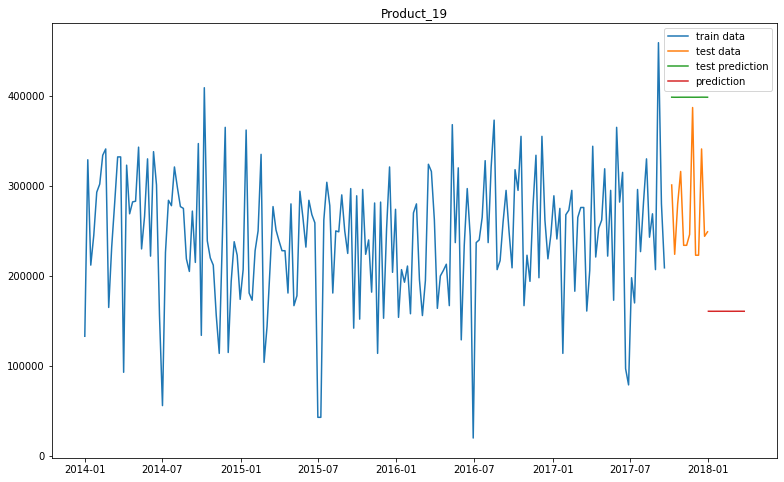

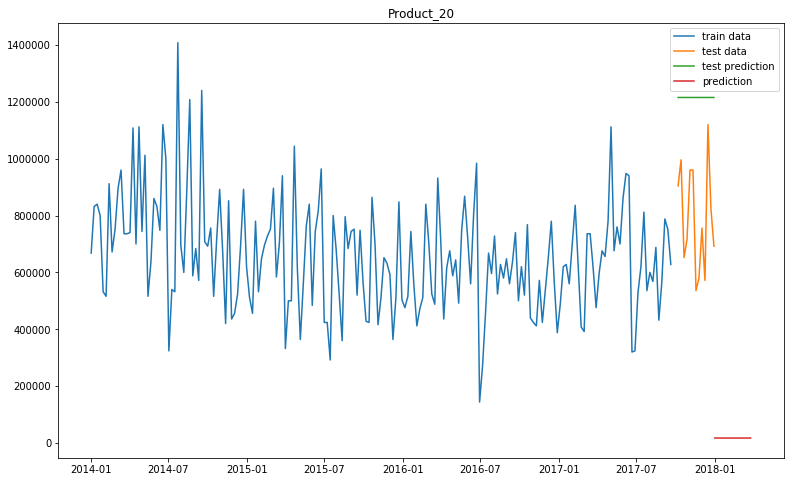

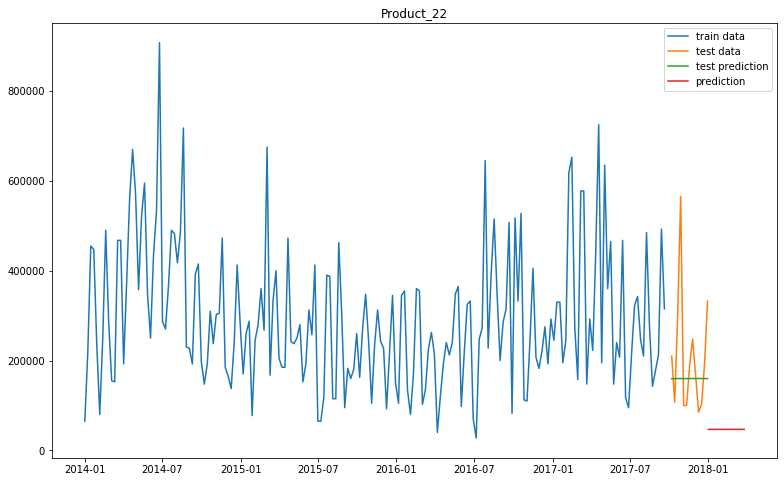

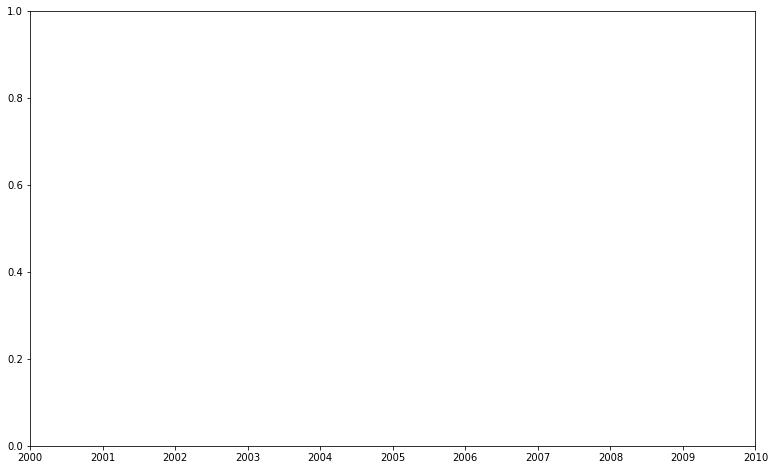

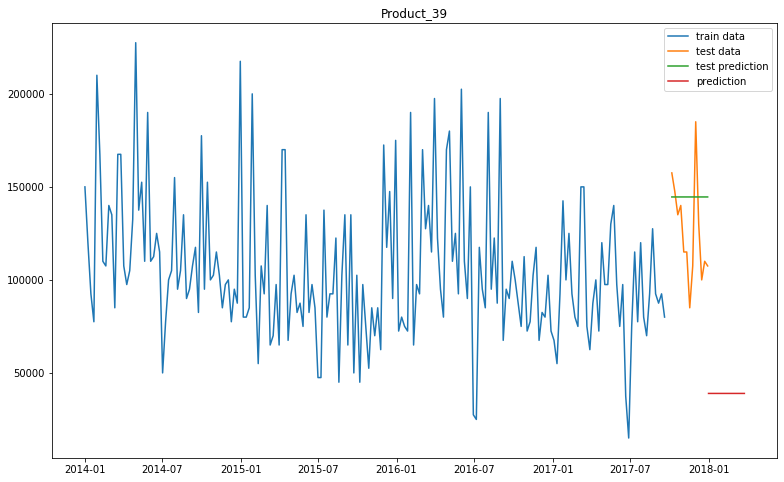

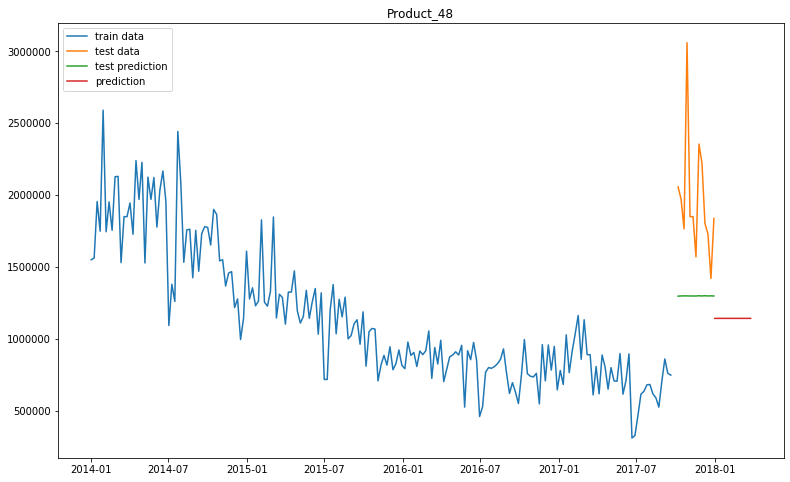

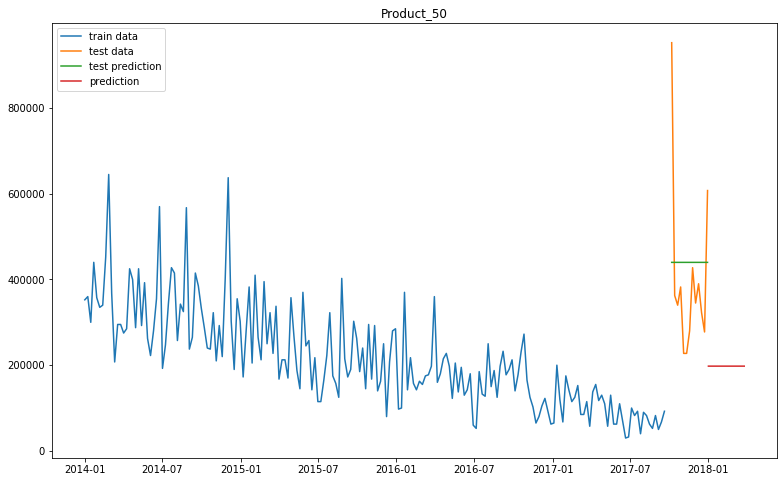

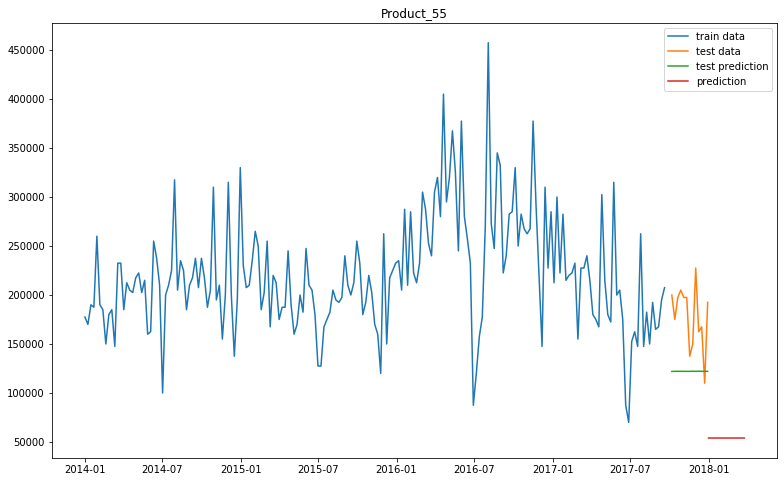

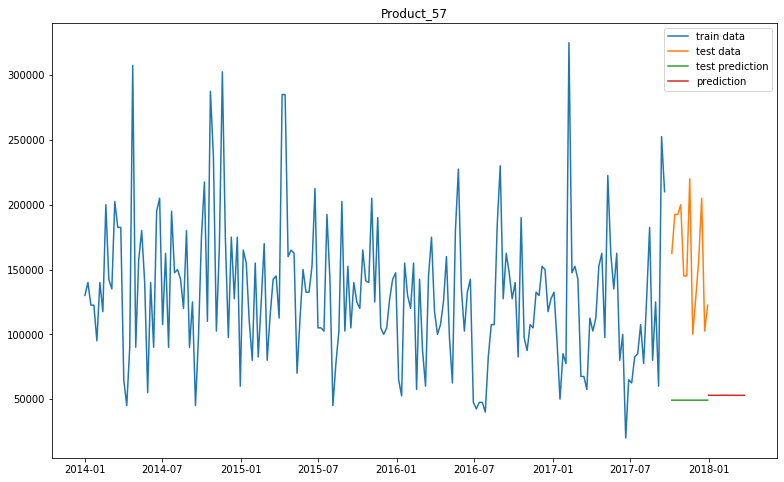

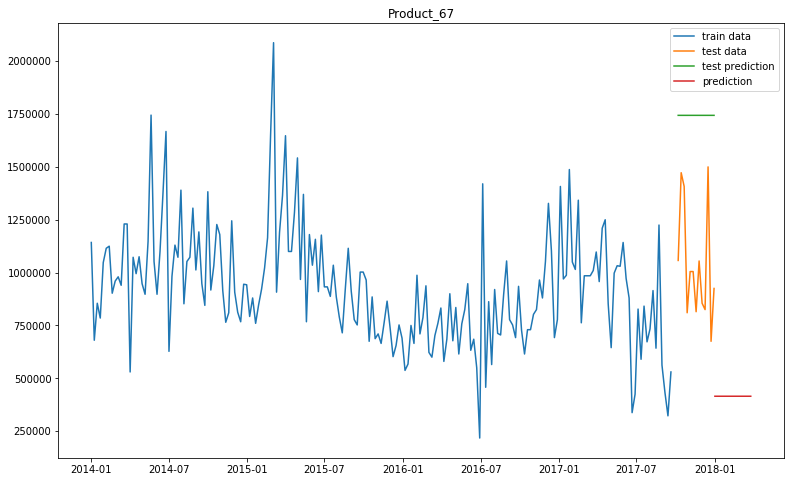

In [292]:
model = TCN_(input_length, output_size, [1,2], 2, 0.1)
model.double()

trainer = Trainer(model, retrain=True, norm=True)
trainer(trains_loaders, tests_loaders, trains, tests, predictions, 0.001, 30)

# Compare stats 

In [294]:
filenames = ['stats_0.json', 'stats_1.json', 'stats_2.json']

DIR = os.path.join(os.getcwd()+"\..\stats")
if not os.path.exists(DIR):
    print("PROVIDE PATH TO FILE MANUALLY")

PATH = os.path.join(DIR, FILE_NAME)

In [298]:
def compare_mae(fname):
    f1 = open(fname, 'r')
    data = json.load(f1)
    f1.close()
    return data

In [306]:
compare_mae(os.path.join(DIR, filenames[1]))['MSE']

{'Product_19': 74351301154.67055,
 'Product_20': 645388012989.3198,
 'Product_22': 52852149126.22657,
 'Product_30': 161438386986.64923,
 'Product_39': 16272296175.395124,
 'Product_48': 3632056496784.68,
 'Product_50': 103606009382.40736,
 'Product_55': 1005690403.2241877,
 'Product_57': 1553658430.3592,
 'Product_67': 913701357219.1294}

In [ ]:
81419.64690841427
